# PIGPVAE cooling R4 model
The main difference to traditional VAE model (Kigma et al., 2014) is that instead of using standard gaussian distibutions on the latent vector $\mathbf{Z} = [\mathbf{z}_1, \ldots, \mathbf{z}_L],$ where $\mathbf{z}_l \sim \mathcal{N}(0, \sigma^2I),$ we use GPs that account for the depedency that we have in time. Therefore we have that $\mathbf{z}_l \sim \mathcal{N}(0, K(t,t'\mid \theta_l)),$ where $K$ is a function that models the correlation that we have in time. 

This is in principle a conditional (in time) generator. Another advantage of using GPs for the latent variables, is that we do not need the data to be equally spaced in time. It is also possible to condition on other features. For example, the outer temperature, solar irradiance, wind, ...

The main drawback with GPs is the cubic in data $\mathcal{O}(N^3)$ cost and the vanilla GP model can not be trained in mini-batches.
To overcome the cost we can use reliable approximations (e.g. Titsias 2009) that reduce the cost to $\mathcal{O}(Nm^2),$ where $m$ is a user the number of so called inducing points (user choice, usually 20-30 is fine). At the same time there are two recent papers that make GPs ammenable to mini-batching (add refs).

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *
from VAE_utils import AnnealingStrategy
from metrics import *

from Models.PIGPVAE_lognorm import PIGPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD420'] + df['RTD417'] + df['B.ASTRHT2.T'])/3 
df_h = df.copy()
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_h = df_h.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_62900/3580172856.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var, exclude_samples=None):
        """
        Args:
            df: DataFrame containing the data.
            select_var: List of variables to include in the dataset.
            exclude_samples: List of samples (intervals) to exclude from the dataset.
        """
        self.df = df
        self.select_var = select_var
        if exclude_samples:
            self.unique_batches = [batch for batch in df['interval'].unique() if batch not in exclude_samples]
        else:
            self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch

# Initialize the dataset, excluding samples 53 and 5
exclude_samples = [53, 5]
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_h, select_var, exclude_samples=exclude_samples)

# Validate the updated dataset
print(f"Dataset length after exclusion: {len(dataset)}")


# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Define a fixed seed for reproducibility

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

Dataset length after exclusion: 29


In [21]:
# Define the range of initial_alpha values for ablation
initial_alpha_values = [0, 0.1, 0.5, 2, 100]
results = {}

# Ensure the directory exists
os.makedirs("pre_trained_models", exist_ok=True)

def train_model(initial_alpha):
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    GP_inf = GP_inference(kernel)
    
    torch.manual_seed(1)
    model = PIGPVAE(GP_inf=GP_inf, 
                    hidden_layers_encoder_delta=[10,10], 
                    hidden_layers_encoder_phy=[10], 
                    hidden_layers_decoder_delta=[10,10],
                    activation_decoder_delta=nn.ELU(),
                    initial_alpha=initial_alpha,
                    trainable_alpha=False,
                    mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
                   )
    
    gp_params = []
    base_params = []
    
    for name, param in model.named_parameters():
        if 'GP' in name:
            gp_params.append(param)  # Gaussian Process parameters
        else:
            base_params.append(param)  # All other parameters
    
    # Define learning rates
    base_lr = 0.001
    gp_lr = 0.0001
    
    opt = torch.optim.Adam([
        {'params': base_params, 'lr': base_lr},
        {'params': gp_params, 'lr': gp_lr}
    ])
    opt.zero_grad()
    
    t_uni = torch.tensor([
        1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.
    ])
    
    num_epochs = 600
    annealing_strategy = AnnealingStrategy(strategy='linear', 
                                           total_epochs=num_epochs, 
                                           beta_min=0.01, 
                                           beta_max=0.01)
    beta_annealed = annealing_strategy.get_beta_vector()
    beta_delta = beta_annealed
    beta_phy = beta_annealed
    
    ns = total_size
    min_T, max_T = 12, 25
    T0 = min_T + (max_T - min_T) * torch.rand(ns)
    difference = 1 + (20 - 1) * torch.rand(ns)
    Ts = T0 + difference
    unique_intervals = df_h['interval'].unique()
    num_unique_intervals = len(unique_intervals)
    
    fit_res = model.fit(
        train_loader=train_loader, 
        val_loader=val_loader, 
        opt=opt, 
        beta_delta=beta_delta,
        beta_phy=beta_phy,
        num_epochs=num_epochs,
        seed=0, plot=False, df=df_h, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(10, 35))
    
    # Save the trained model
    model_path = f'pre_trained_models/ablation/PIGPVAE_heating_alpha_{initial_alpha}.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved at {model_path}')
    
    return fit_res

# Run ablation study
for alpha in initial_alpha_values:
    print(f'Training model with initial_alpha={alpha}')
    fit_results = train_model(alpha)
    results[alpha] = fit_results

Training model with initial_alpha=0


Training Progress:   5%|▌         | 31/600 [00:03<00:54, 10.50it/s]

Epoch 30: Train Loss = 2.2499, KL_phy = 2.5454, KL_delta = 0.0403, MSE = 2.2240, CE = 1.0490, Reg_Loss = 0.1286, Alpha = 0.0000
Validation Loss = 3.0433, Val_KL_phy = 2.5288, Val_KL_delta = 0.0680, Val_MSE = 3.0174, Val_CE = 1.0535, Val_Reg_Loss = 0.1846, Val_Alpha = 0.0000


Training Progress:  10%|█         | 61/600 [00:05<00:51, 10.55it/s]

Epoch 60: Train Loss = 2.0427, KL_phy = 2.3537, KL_delta = 1.6412, MSE = 2.0027, CE = 0.4653, Reg_Loss = 0.2372, Alpha = 0.0000
Validation Loss = 2.6812, Val_KL_phy = 2.3422, Val_KL_delta = 1.7200, Val_MSE = 2.6406, Val_CE = 0.4527, Val_Reg_Loss = 0.3444, Val_Alpha = 0.0000


Training Progress:  15%|█▌        | 91/600 [00:08<00:48, 10.49it/s]

Epoch 90: Train Loss = 1.3072, KL_phy = 1.9295, KL_delta = 4.7535, MSE = 1.2403, CE = 0.2201, Reg_Loss = 0.7688, Alpha = 0.0000
Validation Loss = 1.9963, Val_KL_phy = 1.9096, Val_KL_delta = 4.8292, Val_MSE = 1.9289, Val_CE = 0.2175, Val_Reg_Loss = 1.5429, Val_Alpha = 0.0000


Training Progress:  20%|██        | 122/600 [00:11<00:46, 10.18it/s]

Epoch 120: Train Loss = 0.7128, KL_phy = 1.2811, KL_delta = 7.9967, MSE = 0.6200, CE = 0.2376, Reg_Loss = 3.1742, Alpha = 0.0000
Validation Loss = 1.1527, Val_KL_phy = 1.2670, Val_KL_delta = 8.0644, Val_MSE = 1.0594, Val_CE = 0.2494, Val_Reg_Loss = 5.6270, Val_Alpha = 0.0000


Training Progress:  25%|██▌       | 152/600 [00:14<00:42, 10.58it/s]

Epoch 150: Train Loss = 0.4046, KL_phy = 1.0199, KL_delta = 9.7868, MSE = 0.2966, CE = 0.3138, Reg_Loss = 5.9146, Alpha = 0.0000
Validation Loss = 0.4850, Val_KL_phy = 1.0175, Val_KL_delta = 9.6957, Val_MSE = 0.3779, Val_CE = 0.3146, Val_Reg_Loss = 9.2728, Val_Alpha = 0.0000


Training Progress:  30%|███       | 182/600 [00:17<00:39, 10.60it/s]

Epoch 180: Train Loss = 0.2516, KL_phy = 0.9051, KL_delta = 10.2161, MSE = 0.1404, CE = 0.3427, Reg_Loss = 6.8870, Alpha = 0.0000
Validation Loss = 0.2657, Val_KL_phy = 0.9029, Val_KL_delta = 9.9244, Val_MSE = 0.1575, Val_CE = 0.3431, Val_Reg_Loss = 13.3950, Val_Alpha = 0.0000


Training Progress:  35%|███▌      | 212/600 [00:20<00:36, 10.60it/s]

Epoch 210: Train Loss = 0.2337, KL_phy = 0.8667, KL_delta = 9.9555, MSE = 0.1255, CE = 0.3733, Reg_Loss = 7.4072, Alpha = 0.0000
Validation Loss = 0.2126, Val_KL_phy = 0.8675, Val_KL_delta = 9.7611, Val_MSE = 0.1063, Val_CE = 0.4336, Val_Reg_Loss = 14.8480, Val_Alpha = 0.0000


Training Progress:  40%|████      | 242/600 [00:23<00:33, 10.56it/s]

Epoch 240: Train Loss = 0.2032, KL_phy = 0.8539, KL_delta = 9.4531, MSE = 0.1002, CE = 0.3594, Reg_Loss = 8.4794, Alpha = 0.0000
Validation Loss = 0.2238, Val_KL_phy = 0.8547, Val_KL_delta = 9.2329, Val_MSE = 0.1230, Val_CE = 0.3839, Val_Reg_Loss = 16.8357, Val_Alpha = 0.0000


Training Progress:  45%|████▌     | 271/600 [00:25<00:35,  9.35it/s]

Epoch 270: Train Loss = 0.2331, KL_phy = 0.8445, KL_delta = 8.9627, MSE = 0.1350, CE = 0.3486, Reg_Loss = 9.4267, Alpha = 0.0000
Validation Loss = 0.2505, Val_KL_phy = 0.8441, Val_KL_delta = 8.7108, Val_MSE = 0.1550, Val_CE = 0.3203, Val_Reg_Loss = 17.5734, Val_Alpha = 0.0000


Training Progress:  50%|█████     | 302/600 [00:28<00:28, 10.35it/s]

Epoch 300: Train Loss = 0.2134, KL_phy = 0.8287, KL_delta = 8.4903, MSE = 0.1202, CE = 0.3060, Reg_Loss = 8.9111, Alpha = 0.0000
Validation Loss = 0.1951, Val_KL_phy = 0.8282, Val_KL_delta = 8.2796, Val_MSE = 0.1040, Val_CE = 0.2819, Val_Reg_Loss = 15.4239, Val_Alpha = 0.0000


Training Progress:  55%|█████▌    | 332/600 [00:31<00:25, 10.60it/s]

Epoch 330: Train Loss = 0.2260, KL_phy = 0.8131, KL_delta = 8.1283, MSE = 0.1366, CE = 0.2603, Reg_Loss = 9.4328, Alpha = 0.0000
Validation Loss = 0.2236, Val_KL_phy = 0.8147, Val_KL_delta = 7.9802, Val_MSE = 0.1356, Val_CE = 0.2744, Val_Reg_Loss = 16.6235, Val_Alpha = 0.0000


Training Progress:  60%|██████    | 362/600 [00:34<00:22, 10.61it/s]

Epoch 360: Train Loss = 0.2063, KL_phy = 0.7684, KL_delta = 7.7873, MSE = 0.1208, CE = 0.2480, Reg_Loss = 9.9645, Alpha = 0.0000
Validation Loss = 0.1801, Val_KL_phy = 0.7716, Val_KL_delta = 7.6166, Val_MSE = 0.0962, Val_CE = 0.2580, Val_Reg_Loss = 18.8573, Val_Alpha = 0.0000


Training Progress:  65%|██████▌   | 392/600 [00:37<00:19, 10.62it/s]

Epoch 390: Train Loss = 0.1781, KL_phy = 0.7236, KL_delta = 7.5848, MSE = 0.0950, CE = 0.2522, Reg_Loss = 9.6281, Alpha = 0.0000
Validation Loss = 0.1774, Val_KL_phy = 0.7212, Val_KL_delta = 7.3664, Val_MSE = 0.0965, Val_CE = 0.2578, Val_Reg_Loss = 18.4252, Val_Alpha = 0.0000


Training Progress:  70%|███████   | 422/600 [00:40<00:16, 10.62it/s]

Epoch 420: Train Loss = 0.2011, KL_phy = 0.7203, KL_delta = 7.3021, MSE = 0.1208, CE = 0.2356, Reg_Loss = 9.9626, Alpha = 0.0000
Validation Loss = 0.1815, Val_KL_phy = 0.7152, Val_KL_delta = 7.0919, Val_MSE = 0.1035, Val_CE = 0.2234, Val_Reg_Loss = 18.3724, Val_Alpha = 0.0000


Training Progress:  75%|███████▌  | 451/600 [00:43<00:14, 10.25it/s]

Epoch 450: Train Loss = 0.1862, KL_phy = 0.6977, KL_delta = 7.0137, MSE = 0.1091, CE = 0.2444, Reg_Loss = 10.9878, Alpha = 0.0000
Validation Loss = 0.1852, Val_KL_phy = 0.6982, Val_KL_delta = 6.8620, Val_MSE = 0.1096, Val_CE = 0.2327, Val_Reg_Loss = 17.9704, Val_Alpha = 0.0000


Training Progress:  80%|████████  | 481/600 [00:46<00:11, 10.37it/s]

Epoch 480: Train Loss = 0.1911, KL_phy = 0.6259, KL_delta = 6.8569, MSE = 0.1163, CE = 0.2182, Reg_Loss = 11.2502, Alpha = 0.0000
Validation Loss = 0.1659, Val_KL_phy = 0.6236, Val_KL_delta = 6.6779, Val_MSE = 0.0929, Val_CE = 0.2127, Val_Reg_Loss = 21.0721, Val_Alpha = 0.0000


Training Progress:  85%|████████▌ | 511/600 [00:49<00:08, 10.46it/s]

Epoch 510: Train Loss = 0.1797, KL_phy = 0.5435, KL_delta = 6.6514, MSE = 0.1078, CE = 0.2208, Reg_Loss = 12.3499, Alpha = 0.0000
Validation Loss = 0.1609, Val_KL_phy = 0.5294, Val_KL_delta = 6.4994, Val_MSE = 0.0906, Val_CE = 0.2397, Val_Reg_Loss = 23.7628, Val_Alpha = 0.0000


Training Progress:  90%|█████████ | 541/600 [00:51<00:05, 10.50it/s]

Epoch 540: Train Loss = 0.2019, KL_phy = 0.4538, KL_delta = 6.5132, MSE = 0.1322, CE = 0.2180, Reg_Loss = 14.4962, Alpha = 0.0000
Validation Loss = 0.1614, Val_KL_phy = 0.4506, Val_KL_delta = 6.4055, Val_MSE = 0.0928, Val_CE = 0.2019, Val_Reg_Loss = 23.3625, Val_Alpha = 0.0000


Training Progress:  95%|█████████▌| 571/600 [00:54<00:02, 10.51it/s]

Epoch 570: Train Loss = 0.1988, KL_phy = 0.4177, KL_delta = 6.2954, MSE = 0.1317, CE = 0.2147, Reg_Loss = 16.0677, Alpha = 0.0000
Validation Loss = 0.1741, Val_KL_phy = 0.4179, Val_KL_delta = 6.1568, Val_MSE = 0.1084, Val_CE = 0.2111, Val_Reg_Loss = 25.4867, Val_Alpha = 0.0000


Training Progress: 100%|██████████| 600/600 [00:57<00:00, 10.43it/s]


Epoch 600: Train Loss = 0.1864, KL_phy = 0.4051, KL_delta = 6.2369, MSE = 0.1200, CE = 0.1901, Reg_Loss = 14.4935, Alpha = 0.0000
Validation Loss = 0.1847, Val_KL_phy = 0.4020, Val_KL_delta = 6.0938, Val_MSE = 0.1197, Val_CE = 0.1929, Val_Reg_Loss = 25.1794, Val_Alpha = 0.0000
Model saved at pre_trained_models/ablation/PIGPVAE_heating_alpha_0.pth
Training model with initial_alpha=0.1


Training Progress:   5%|▌         | 32/600 [00:03<00:53, 10.56it/s]

Epoch 30: Train Loss = 2.2704, KL_phy = 2.5248, KL_delta = 0.0357, MSE = 2.2345, CE = 1.0413, Reg_Loss = 0.1030, Alpha = 0.1000
Validation Loss = 3.0436, Val_KL_phy = 2.5075, Val_KL_delta = 0.0633, Val_MSE = 3.0030, Val_CE = 1.0455, Val_Reg_Loss = 0.1487, Val_Alpha = 0.1000


Training Progress:  10%|█         | 62/600 [00:05<00:50, 10.58it/s]

Epoch 60: Train Loss = 2.0798, KL_phy = 2.3276, KL_delta = 1.6193, MSE = 2.0198, CE = 0.4418, Reg_Loss = 0.2051, Alpha = 0.1000
Validation Loss = 2.7155, Val_KL_phy = 2.3178, Val_KL_delta = 1.6944, Val_MSE = 2.6463, Val_CE = 0.4311, Val_Reg_Loss = 0.2907, Val_Alpha = 0.1000


Training Progress:  15%|█▌        | 92/600 [00:08<00:48, 10.58it/s]

Epoch 90: Train Loss = 1.4038, KL_phy = 2.0638, KL_delta = 4.6361, MSE = 1.2823, CE = 0.2181, Reg_Loss = 0.5454, Alpha = 0.1000
Validation Loss = 2.2336, Val_KL_phy = 2.0455, Val_KL_delta = 4.7136, Val_MSE = 2.0604, Val_CE = 0.2146, Val_Reg_Loss = 1.0569, Val_Alpha = 0.1000


Training Progress:  20%|██        | 122/600 [00:11<00:45, 10.51it/s]

Epoch 120: Train Loss = 0.9072, KL_phy = 1.9233, KL_delta = 7.8314, MSE = 0.7151, CE = 0.2303, Reg_Loss = 0.9457, Alpha = 0.1000
Validation Loss = 1.4890, Val_KL_phy = 1.9096, Val_KL_delta = 7.9064, Val_MSE = 1.2025, Val_CE = 0.2411, Val_Reg_Loss = 1.8837, Val_Alpha = 0.1000


Training Progress:  25%|██▌       | 152/600 [00:14<00:42, 10.52it/s]

Epoch 150: Train Loss = 0.5566, KL_phy = 2.0841, KL_delta = 9.8107, MSE = 0.2873, CE = 0.2853, Reg_Loss = 1.5028, Alpha = 0.1000
Validation Loss = 0.6172, Val_KL_phy = 2.0849, Val_KL_delta = 9.6735, Val_MSE = 0.3103, Val_CE = 0.2876, Val_Reg_Loss = 1.8931, Val_Alpha = 0.1000


Training Progress:  30%|███       | 180/600 [00:17<00:42,  9.97it/s]

Epoch 180: Train Loss = 0.4290, KL_phy = 2.1886, KL_delta = 10.1430, MSE = 0.1403, CE = 0.2859, Reg_Loss = 1.6530, Alpha = 0.1000
Validation Loss = 0.5058, Val_KL_phy = 2.1792, Val_KL_delta = 9.8695, Val_MSE = 0.1582, Val_CE = 0.2896, Val_Reg_Loss = 2.2714, Val_Alpha = 0.1000


Training Progress:  35%|███▌      | 211/600 [00:20<00:36, 10.53it/s]

Epoch 210: Train Loss = 0.4151, KL_phy = 2.3025, KL_delta = 9.5932, MSE = 0.1334, CE = 0.2758, Reg_Loss = 1.6279, Alpha = 0.1000
Validation Loss = 0.4614, Val_KL_phy = 2.2891, Val_KL_delta = 9.3696, Val_MSE = 0.1198, Val_CE = 0.2926, Val_Reg_Loss = 2.2497, Val_Alpha = 0.1000


Training Progress:  40%|████      | 241/600 [00:23<00:34, 10.29it/s]

Epoch 240: Train Loss = 0.4095, KL_phy = 2.2959, KL_delta = 8.8788, MSE = 0.1210, CE = 0.2645, Reg_Loss = 1.7677, Alpha = 0.1000
Validation Loss = 0.5330, Val_KL_phy = 2.2928, Val_KL_delta = 8.6719, Val_MSE = 0.1646, Val_CE = 0.2762, Val_Reg_Loss = 2.5878, Val_Alpha = 0.1000


Training Progress:  45%|████▌     | 271/600 [00:26<00:31, 10.33it/s]

Epoch 270: Train Loss = 0.4283, KL_phy = 2.3155, KL_delta = 8.3820, MSE = 0.1394, CE = 0.2562, Reg_Loss = 1.8195, Alpha = 0.1000
Validation Loss = 0.5197, Val_KL_phy = 2.3170, Val_KL_delta = 8.1757, Val_MSE = 0.1558, Val_CE = 0.2507, Val_Reg_Loss = 2.5896, Val_Alpha = 0.1000


Training Progress:  50%|█████     | 301/600 [00:28<00:28, 10.44it/s]

Epoch 300: Train Loss = 0.4298, KL_phy = 2.3718, KL_delta = 7.9603, MSE = 0.1398, CE = 0.2431, Reg_Loss = 1.8671, Alpha = 0.1000
Validation Loss = 0.4982, Val_KL_phy = 2.3576, Val_KL_delta = 7.7579, Val_MSE = 0.1332, Val_CE = 0.2316, Val_Reg_Loss = 2.6381, Val_Alpha = 0.1000


Training Progress:  55%|█████▌    | 331/600 [00:31<00:26, 10.15it/s]

Epoch 330: Train Loss = 0.4544, KL_phy = 2.3717, KL_delta = 7.5975, MSE = 0.1740, CE = 0.2260, Reg_Loss = 1.8073, Alpha = 0.1000
Validation Loss = 0.5258, Val_KL_phy = 2.3655, Val_KL_delta = 7.4766, Val_MSE = 0.1989, Val_CE = 0.2378, Val_Reg_Loss = 2.2845, Val_Alpha = 0.1000


Training Progress:  60%|██████    | 361/600 [00:34<00:23, 10.25it/s]

Epoch 360: Train Loss = 0.4419, KL_phy = 2.3738, KL_delta = 7.3184, MSE = 0.1518, CE = 0.2215, Reg_Loss = 1.9318, Alpha = 0.1000
Validation Loss = 0.5043, Val_KL_phy = 2.3707, Val_KL_delta = 7.1582, Val_MSE = 0.1530, Val_CE = 0.2265, Val_Reg_Loss = 2.5606, Val_Alpha = 0.1000


Training Progress:  65%|██████▌   | 391/600 [00:37<00:20, 10.44it/s]

Epoch 390: Train Loss = 0.3826, KL_phy = 2.4490, KL_delta = 7.1112, MSE = 0.1160, CE = 0.2197, Reg_Loss = 1.7101, Alpha = 0.1000
Validation Loss = 0.4495, Val_KL_phy = 2.4217, Val_KL_delta = 6.9118, Val_MSE = 0.1211, Val_CE = 0.2214, Val_Reg_Loss = 2.3508, Val_Alpha = 0.1000


Training Progress:  70%|███████   | 421/600 [00:40<00:17, 10.47it/s]

Epoch 420: Train Loss = 0.3972, KL_phy = 2.4648, KL_delta = 6.8869, MSE = 0.1282, CE = 0.2150, Reg_Loss = 1.7549, Alpha = 0.1000
Validation Loss = 0.4419, Val_KL_phy = 2.4440, Val_KL_delta = 6.6831, Val_MSE = 0.1179, Val_CE = 0.2056, Val_Reg_Loss = 2.3264, Val_Alpha = 0.1000


Training Progress:  75%|███████▌  | 451/600 [00:43<00:14, 10.39it/s]

Epoch 450: Train Loss = 0.3888, KL_phy = 2.4973, KL_delta = 6.6556, MSE = 0.1339, CE = 0.2137, Reg_Loss = 1.6338, Alpha = 0.1000
Validation Loss = 0.4863, Val_KL_phy = 2.4829, Val_KL_delta = 6.5147, Val_MSE = 0.1659, Val_CE = 0.2094, Val_Reg_Loss = 2.3036, Val_Alpha = 0.1000


Training Progress:  80%|████████  | 481/600 [00:46<00:11, 10.45it/s]

Epoch 480: Train Loss = 0.3923, KL_phy = 2.4939, KL_delta = 6.4903, MSE = 0.1306, CE = 0.2009, Reg_Loss = 1.7192, Alpha = 0.1000
Validation Loss = 0.4742, Val_KL_phy = 2.4729, Val_KL_delta = 6.3221, Val_MSE = 0.1329, Val_CE = 0.1978, Val_Reg_Loss = 2.5339, Val_Alpha = 0.1000


Training Progress:  85%|████████▌ | 511/600 [00:49<00:09,  9.75it/s]

Epoch 510: Train Loss = 0.3749, KL_phy = 2.4898, KL_delta = 6.3184, MSE = 0.1164, CE = 0.1962, Reg_Loss = 1.7042, Alpha = 0.1000
Validation Loss = 0.5102, Val_KL_phy = 2.4668, Val_KL_delta = 6.1702, Val_MSE = 0.1502, Val_CE = 0.2080, Val_Reg_Loss = 2.7364, Val_Alpha = 0.1000


Training Progress:  90%|█████████ | 542/600 [00:52<00:05, 10.32it/s]

Epoch 540: Train Loss = 0.3961, KL_phy = 2.4089, KL_delta = 6.1632, MSE = 0.1426, CE = 0.2043, Reg_Loss = 1.6778, Alpha = 0.1000
Validation Loss = 0.4727, Val_KL_phy = 2.3998, Val_KL_delta = 6.0428, Val_MSE = 0.1189, Val_CE = 0.1929, Val_Reg_Loss = 2.6936, Val_Alpha = 0.1000


Training Progress:  95%|█████████▌| 572/600 [00:55<00:02, 10.43it/s]

Epoch 570: Train Loss = 0.4020, KL_phy = 2.4131, KL_delta = 6.0057, MSE = 0.1473, CE = 0.2088, Reg_Loss = 1.7053, Alpha = 0.1000
Validation Loss = 0.5119, Val_KL_phy = 2.4139, Val_KL_delta = 5.8725, Val_MSE = 0.1629, Val_CE = 0.2048, Val_Reg_Loss = 2.6606, Val_Alpha = 0.1000


Training Progress: 100%|██████████| 600/600 [00:57<00:00, 10.36it/s]


Epoch 600: Train Loss = 0.3771, KL_phy = 2.4369, KL_delta = 5.8859, MSE = 0.1380, CE = 0.1964, Reg_Loss = 1.5581, Alpha = 0.1000
Validation Loss = 0.5210, Val_KL_phy = 2.4082, Val_KL_delta = 5.7599, Val_MSE = 0.2074, Val_CE = 0.2080, Val_Reg_Loss = 2.3190, Val_Alpha = 0.1000
Model saved at pre_trained_models/ablation/PIGPVAE_heating_alpha_0.1.pth
Training model with initial_alpha=0.5


Training Progress:   5%|▌         | 31/600 [00:02<00:54, 10.43it/s]

Epoch 30: Train Loss = 2.3230, KL_phy = 2.4711, KL_delta = -0.0516, MSE = 2.2709, CE = 0.9266, Reg_Loss = 0.0558, Alpha = 0.5000
Validation Loss = 3.0737, Val_KL_phy = 2.4545, Val_KL_delta = -0.0308, Val_MSE = 3.0088, Val_CE = 0.9267, Val_Reg_Loss = 0.0813, Val_Alpha = 0.5000


Training Progress:  10%|█         | 61/600 [00:05<00:51, 10.44it/s]

Epoch 60: Train Loss = 2.2141, KL_phy = 2.3150, KL_delta = 1.1740, MSE = 2.1190, CE = 0.3549, Reg_Loss = 0.1204, Alpha = 0.5000
Validation Loss = 2.8531, Val_KL_phy = 2.3085, Val_KL_delta = 1.2229, Val_MSE = 2.7343, Val_CE = 0.3554, Val_Reg_Loss = 0.1670, Val_Alpha = 0.5000


Training Progress:  15%|█▌        | 91/600 [00:08<00:49, 10.33it/s]

Epoch 90: Train Loss = 1.6503, KL_phy = 2.2382, KL_delta = 3.4765, MSE = 1.4745, CE = 0.1739, Reg_Loss = 0.2372, Alpha = 0.5000
Validation Loss = 2.7980, Val_KL_phy = 2.2140, Val_KL_delta = 3.5182, Val_MSE = 2.5351, Val_CE = 0.1703, Val_Reg_Loss = 0.4112, Val_Alpha = 0.5000


Training Progress:  20%|██        | 121/600 [00:11<00:45, 10.42it/s]

Epoch 120: Train Loss = 1.2286, KL_phy = 2.2052, KL_delta = 6.2281, MSE = 0.9353, CE = 0.1847, Reg_Loss = 0.4178, Alpha = 0.5000
Validation Loss = 2.0553, Val_KL_phy = 2.1829, Val_KL_delta = 6.2975, Val_MSE = 1.5833, Val_CE = 0.1936, Val_Reg_Loss = 0.7743, Val_Alpha = 0.5000


Training Progress:  25%|██▌       | 151/600 [00:14<00:43, 10.31it/s]

Epoch 150: Train Loss = 1.0013, KL_phy = 2.2837, KL_delta = 8.0197, MSE = 0.4955, CE = 0.2234, Reg_Loss = 0.8054, Alpha = 0.5000
Validation Loss = 1.0905, Val_KL_phy = 2.2781, Val_KL_delta = 7.8787, Val_MSE = 0.5297, Val_CE = 0.2283, Val_Reg_Loss = 0.9184, Val_Alpha = 0.5000


Training Progress:  30%|███       | 181/600 [00:17<00:40, 10.38it/s]

Epoch 180: Train Loss = 0.9051, KL_phy = 2.2753, KL_delta = 8.2253, MSE = 0.3563, CE = 0.2267, Reg_Loss = 0.8875, Alpha = 0.5000
Validation Loss = 1.1397, Val_KL_phy = 2.2573, Val_KL_delta = 8.0053, Val_MSE = 0.4385, Val_CE = 0.2300, Val_Reg_Loss = 1.1972, Val_Alpha = 0.5000


Training Progress:  35%|███▌      | 211/600 [00:20<00:37, 10.38it/s]

Epoch 210: Train Loss = 0.8728, KL_phy = 2.3920, KL_delta = 7.7109, MSE = 0.3374, CE = 0.2154, Reg_Loss = 0.8687, Alpha = 0.5000
Validation Loss = 1.1229, Val_KL_phy = 2.3612, Val_KL_delta = 7.5251, Val_MSE = 0.4163, Val_CE = 0.2220, Val_Reg_Loss = 1.2155, Val_Alpha = 0.5000


Training Progress:  40%|████      | 241/600 [00:23<00:36,  9.82it/s]

Epoch 240: Train Loss = 0.9112, KL_phy = 2.4387, KL_delta = 7.1257, MSE = 0.3530, CE = 0.2031, Reg_Loss = 0.9251, Alpha = 0.5000
Validation Loss = 1.3075, Val_KL_phy = 2.4244, Val_KL_delta = 6.9592, Val_MSE = 0.5381, Val_CE = 0.2088, Val_Reg_Loss = 1.3511, Val_Alpha = 0.5000


Training Progress:  45%|████▌     | 271/600 [00:26<00:31, 10.32it/s]

Epoch 270: Train Loss = 0.9161, KL_phy = 2.4691, KL_delta = 6.7488, MSE = 0.3560, CE = 0.1951, Reg_Loss = 0.9359, Alpha = 0.5000
Validation Loss = 1.2746, Val_KL_phy = 2.4640, Val_KL_delta = 6.5844, Val_MSE = 0.5007, Val_CE = 0.1943, Val_Reg_Loss = 1.3668, Val_Alpha = 0.5000


Training Progress:  50%|█████     | 301/600 [00:29<00:28, 10.35it/s]

Epoch 300: Train Loss = 0.9489, KL_phy = 2.5434, KL_delta = 6.4255, MSE = 0.3748, CE = 0.1881, Reg_Loss = 0.9688, Alpha = 0.5000
Validation Loss = 1.2518, Val_KL_phy = 2.5199, Val_KL_delta = 6.2626, Val_MSE = 0.4724, Val_CE = 0.1829, Val_Reg_Loss = 1.3832, Val_Alpha = 0.5000


Training Progress:  55%|█████▌    | 332/600 [00:32<00:25, 10.31it/s]

Epoch 330: Train Loss = 0.9709, KL_phy = 2.5591, KL_delta = 6.1715, MSE = 0.4261, CE = 0.1780, Reg_Loss = 0.9150, Alpha = 0.5000
Validation Loss = 1.2713, Val_KL_phy = 2.5486, Val_KL_delta = 6.0724, Val_MSE = 0.5721, Val_CE = 0.1846, Val_Reg_Loss = 1.2259, Val_Alpha = 0.5000


Training Progress:  60%|██████    | 362/600 [00:35<00:23, 10.27it/s]

Epoch 360: Train Loss = 0.9771, KL_phy = 2.5865, KL_delta = 5.9503, MSE = 0.4042, CE = 0.1750, Reg_Loss = 0.9751, Alpha = 0.5000
Validation Loss = 1.3085, Val_KL_phy = 2.5800, Val_KL_delta = 5.8144, Val_MSE = 0.5459, Val_CE = 0.1763, Val_Reg_Loss = 1.3573, Val_Alpha = 0.5000


Training Progress:  65%|██████▌   | 392/600 [00:38<00:20, 10.36it/s]

Epoch 390: Train Loss = 0.8561, KL_phy = 2.7018, KL_delta = 5.8105, MSE = 0.3222, CE = 0.1728, Reg_Loss = 0.8975, Alpha = 0.5000
Validation Loss = 1.1726, Val_KL_phy = 2.6737, Val_KL_delta = 5.6504, Val_MSE = 0.4484, Val_CE = 0.1725, Val_Reg_Loss = 1.2819, Val_Alpha = 0.5000


Training Progress:  70%|███████   | 421/600 [00:40<00:17, 10.35it/s]

Epoch 420: Train Loss = 0.8787, KL_phy = 2.7310, KL_delta = 5.6324, MSE = 0.3348, CE = 0.1697, Reg_Loss = 0.9206, Alpha = 0.5000
Validation Loss = 1.1431, Val_KL_phy = 2.7099, Val_KL_delta = 5.4647, Val_MSE = 0.4096, Val_CE = 0.1637, Val_Reg_Loss = 1.3037, Val_Alpha = 0.5000


Training Progress:  75%|███████▌  | 451/600 [00:43<00:14, 10.35it/s]

Epoch 450: Train Loss = 0.8717, KL_phy = 2.7800, KL_delta = 5.4554, MSE = 0.3582, CE = 0.1667, Reg_Loss = 0.8623, Alpha = 0.5000
Validation Loss = 1.2353, Val_KL_phy = 2.7649, Val_KL_delta = 5.3346, Val_MSE = 0.5381, Val_CE = 0.1638, Val_Reg_Loss = 1.2325, Val_Alpha = 0.5000


Training Progress:  80%|████████  | 481/600 [00:46<00:11, 10.35it/s]

Epoch 480: Train Loss = 0.8764, KL_phy = 2.7774, KL_delta = 5.3234, MSE = 0.3351, CE = 0.1597, Reg_Loss = 0.9207, Alpha = 0.5000
Validation Loss = 1.2471, Val_KL_phy = 2.7556, Val_KL_delta = 5.1774, Val_MSE = 0.4842, Val_CE = 0.1566, Val_Reg_Loss = 1.3672, Val_Alpha = 0.5000


Training Progress:  85%|████████▌ | 511/600 [00:49<00:08, 10.35it/s]

Epoch 510: Train Loss = 0.8552, KL_phy = 2.8325, KL_delta = 5.1654, MSE = 0.3296, CE = 0.1584, Reg_Loss = 0.8913, Alpha = 0.5000
Validation Loss = 1.3259, Val_KL_phy = 2.8135, Val_KL_delta = 5.0430, Val_MSE = 0.5499, Val_CE = 0.1608, Val_Reg_Loss = 1.3949, Val_Alpha = 0.5000


Training Progress:  90%|█████████ | 541/600 [00:52<00:05, 10.35it/s]

Epoch 540: Train Loss = 0.8830, KL_phy = 2.7494, KL_delta = 5.0508, MSE = 0.3664, CE = 0.1604, Reg_Loss = 0.8772, Alpha = 0.5000
Validation Loss = 1.2557, Val_KL_phy = 2.7366, Val_KL_delta = 4.9470, Val_MSE = 0.4531, Val_CE = 0.1525, Val_Reg_Loss = 1.4516, Val_Alpha = 0.5000


Training Progress:  95%|█████████▌| 572/600 [00:55<00:02,  9.74it/s]

Epoch 570: Train Loss = 0.8906, KL_phy = 2.6981, KL_delta = 4.9404, MSE = 0.3635, CE = 0.1636, Reg_Loss = 0.9013, Alpha = 0.5000
Validation Loss = 1.3036, Val_KL_phy = 2.6938, Val_KL_delta = 4.8195, Val_MSE = 0.5279, Val_CE = 0.1590, Val_Reg_Loss = 1.4011, Val_Alpha = 0.5000


Training Progress: 100%|██████████| 600/600 [00:58<00:00, 10.28it/s]


Epoch 600: Train Loss = 0.8380, KL_phy = 2.7150, KL_delta = 4.8339, MSE = 0.3431, CE = 0.1570, Reg_Loss = 0.8388, Alpha = 0.5000
Validation Loss = 1.2922, Val_KL_phy = 2.6880, Val_KL_delta = 4.7330, Val_MSE = 0.6046, Val_CE = 0.1636, Val_Reg_Loss = 1.2267, Val_Alpha = 0.5000
Model saved at pre_trained_models/ablation/PIGPVAE_heating_alpha_0.5.pth
Training model with initial_alpha=2


Training Progress:   5%|▌         | 32/600 [00:03<00:56, 10.11it/s]

Epoch 30: Train Loss = 2.4022, KL_phy = 2.4536, KL_delta = -0.1591, MSE = 2.3403, CE = 1.1716, Reg_Loss = 0.0195, Alpha = 2.0000
Validation Loss = 3.1326, Val_KL_phy = 2.4371, Val_KL_delta = -0.1383, Val_MSE = 3.0460, Val_CE = 1.1721, Val_Reg_Loss = 0.0318, Val_Alpha = 2.0000


Training Progress:  10%|█         | 62/600 [00:06<00:52, 10.33it/s]

Epoch 60: Train Loss = 2.4045, KL_phy = 2.3259, KL_delta = 0.7997, MSE = 2.3099, CE = 0.6127, Reg_Loss = 0.0317, Alpha = 2.0000
Validation Loss = 3.0362, Val_KL_phy = 2.3221, Val_KL_delta = 0.8368, Val_MSE = 2.9170, Val_CE = 0.6075, Val_Reg_Loss = 0.0438, Val_Alpha = 2.0000


Training Progress:  15%|█▌        | 92/600 [00:08<00:49, 10.31it/s]

Epoch 90: Train Loss = 1.9124, KL_phy = 2.3094, KL_delta = 2.7652, MSE = 1.7587, CE = 0.2000, Reg_Loss = 0.0515, Alpha = 2.0000
Validation Loss = 3.4009, Val_KL_phy = 2.2779, Val_KL_delta = 2.7996, Val_MSE = 3.2013, Val_CE = 0.1896, Val_Reg_Loss = 0.0744, Val_Alpha = 2.0000


Training Progress:  20%|██        | 122/600 [00:11<00:46, 10.20it/s]

Epoch 120: Train Loss = 1.6610, KL_phy = 2.2821, KL_delta = 5.1804, MSE = 1.4058, CE = 0.1590, Reg_Loss = 0.0903, Alpha = 2.0000
Validation Loss = 2.8369, Val_KL_phy = 2.2531, Val_KL_delta = 5.2715, Val_MSE = 2.4285, Val_CE = 0.1673, Val_Reg_Loss = 0.1666, Val_Alpha = 2.0000


Training Progress:  25%|██▌       | 152/600 [00:14<00:44, 10.15it/s]

Epoch 150: Train Loss = 1.6449, KL_phy = 2.3378, KL_delta = 6.6415, MSE = 1.1539, CE = 0.2022, Reg_Loss = 0.2006, Alpha = 2.0000
Validation Loss = 1.8329, Val_KL_phy = 2.3290, Val_KL_delta = 6.4965, Val_MSE = 1.2714, Val_CE = 0.2005, Val_Reg_Loss = 0.2366, Val_Alpha = 2.0000


Training Progress:  30%|███       | 182/600 [00:17<00:41, 10.16it/s]

Epoch 180: Train Loss = 1.5569, KL_phy = 2.3290, KL_delta = 6.4074, MSE = 1.0315, CE = 0.1941, Reg_Loss = 0.2190, Alpha = 2.0000
Validation Loss = 2.0432, Val_KL_phy = 2.3069, Val_KL_delta = 6.2248, Val_MSE = 1.3456, Val_CE = 0.1947, Val_Reg_Loss = 0.3062, Val_Alpha = 2.0000


Training Progress:  35%|███▌      | 212/600 [00:20<00:38, 10.21it/s]

Epoch 210: Train Loss = 1.4952, KL_phy = 2.4495, KL_delta = 5.6830, MSE = 0.9928, CE = 0.1794, Reg_Loss = 0.2105, Alpha = 2.0000
Validation Loss = 2.0565, Val_KL_phy = 2.4149, Val_KL_delta = 5.5562, Val_MSE = 1.3643, Val_CE = 0.1914, Val_Reg_Loss = 0.3062, Val_Alpha = 2.0000


Training Progress:  40%|████      | 242/600 [00:23<00:35, 10.08it/s]

Epoch 240: Train Loss = 1.5883, KL_phy = 2.5296, KL_delta = 5.0515, MSE = 1.0664, CE = 0.1666, Reg_Loss = 0.2230, Alpha = 2.0000
Validation Loss = 2.3664, Val_KL_phy = 2.5129, Val_KL_delta = 4.9349, Val_MSE = 1.6383, Val_CE = 0.1744, Val_Reg_Loss = 0.3268, Val_Alpha = 2.0000


Training Progress:  45%|████▌     | 272/600 [00:26<00:32, 10.23it/s]

Epoch 270: Train Loss = 1.5713, KL_phy = 2.5733, KL_delta = 4.6567, MSE = 1.0453, CE = 0.1582, Reg_Loss = 0.2269, Alpha = 2.0000
Validation Loss = 2.3046, Val_KL_phy = 2.5658, Val_KL_delta = 4.5473, Val_MSE = 1.5617, Val_CE = 0.1534, Val_Reg_Loss = 0.3359, Val_Alpha = 2.0000


Training Progress:  50%|█████     | 302/600 [00:29<00:29,  9.99it/s]

Epoch 300: Train Loss = 1.6356, KL_phy = 2.6586, KL_delta = 4.3595, MSE = 1.0901, CE = 0.1489, Reg_Loss = 0.2377, Alpha = 2.0000
Validation Loss = 2.2803, Val_KL_phy = 2.6364, Val_KL_delta = 4.2439, Val_MSE = 1.5196, Val_CE = 0.1392, Val_Reg_Loss = 0.3459, Val_Alpha = 2.0000


Training Progress:  55%|█████▌    | 331/600 [00:32<00:26, 10.24it/s]

Epoch 330: Train Loss = 1.6548, KL_phy = 2.6853, KL_delta = 4.1371, MSE = 1.1470, CE = 0.1375, Reg_Loss = 0.2198, Alpha = 2.0000
Validation Loss = 2.2820, Val_KL_phy = 2.6750, Val_KL_delta = 4.0697, Val_MSE = 1.6103, Val_CE = 0.1434, Val_Reg_Loss = 0.3021, Val_Alpha = 2.0000


Training Progress:  60%|██████    | 361/600 [00:35<00:23, 10.21it/s]

Epoch 360: Train Loss = 1.6851, KL_phy = 2.7287, KL_delta = 3.9494, MSE = 1.1470, CE = 0.1341, Reg_Loss = 0.2357, Alpha = 2.0000
Validation Loss = 2.3888, Val_KL_phy = 2.7213, Val_KL_delta = 3.8538, Val_MSE = 1.6560, Val_CE = 0.1356, Val_Reg_Loss = 0.3335, Val_Alpha = 2.0000


Training Progress:  65%|██████▌   | 391/600 [00:38<00:20, 10.17it/s]

Epoch 390: Train Loss = 1.4958, KL_phy = 2.8577, KL_delta = 3.8386, MSE = 0.9928, CE = 0.1340, Reg_Loss = 0.2180, Alpha = 2.0000
Validation Loss = 2.1749, Val_KL_phy = 2.8312, Val_KL_delta = 3.7243, Val_MSE = 1.4658, Val_CE = 0.1327, Val_Reg_Loss = 0.3218, Val_Alpha = 2.0000


Training Progress:  70%|███████   | 421/600 [00:41<00:17, 10.29it/s]

Epoch 420: Train Loss = 1.5300, KL_phy = 2.8911, KL_delta = 3.6905, MSE = 1.0164, CE = 0.1309, Reg_Loss = 0.2239, Alpha = 2.0000
Validation Loss = 2.1241, Val_KL_phy = 2.8710, Val_KL_delta = 3.5729, Val_MSE = 1.4056, Val_CE = 0.1227, Val_Reg_Loss = 0.3270, Val_Alpha = 2.0000


Training Progress:  75%|███████▌  | 451/600 [00:44<00:14, 10.22it/s]

Epoch 450: Train Loss = 1.5245, KL_phy = 2.9491, KL_delta = 3.5573, MSE = 1.0352, CE = 0.1292, Reg_Loss = 0.2121, Alpha = 2.0000
Validation Loss = 2.2692, Val_KL_phy = 2.9339, Val_KL_delta = 3.4696, Val_MSE = 1.5830, Val_CE = 0.1242, Val_Reg_Loss = 0.3111, Val_Alpha = 2.0000


Training Progress:  80%|████████  | 481/600 [00:47<00:11, 10.26it/s]

Epoch 480: Train Loss = 1.5328, KL_phy = 2.9482, KL_delta = 3.4561, MSE = 1.0090, CE = 0.1204, Reg_Loss = 0.2299, Alpha = 2.0000
Validation Loss = 2.3156, Val_KL_phy = 2.9274, Val_KL_delta = 3.3474, Val_MSE = 1.5663, Val_CE = 0.1155, Val_Reg_Loss = 0.3433, Val_Alpha = 2.0000


Training Progress:  85%|████████▌ | 511/600 [00:50<00:08, 10.27it/s]

Epoch 510: Train Loss = 1.5037, KL_phy = 3.0314, KL_delta = 3.3438, MSE = 1.0040, CE = 0.1179, Reg_Loss = 0.2180, Alpha = 2.0000
Validation Loss = 2.4385, Val_KL_phy = 3.0130, Val_KL_delta = 3.2570, Val_MSE = 1.6954, Val_CE = 0.1221, Val_Reg_Loss = 0.3402, Val_Alpha = 2.0000


Training Progress:  90%|█████████ | 541/600 [00:53<00:05, 10.28it/s]

Epoch 540: Train Loss = 1.5352, KL_phy = 2.9523, KL_delta = 3.2578, MSE = 1.0411, CE = 0.1219, Reg_Loss = 0.2160, Alpha = 2.0000
Validation Loss = 2.3435, Val_KL_phy = 2.9370, Val_KL_delta = 3.1842, Val_MSE = 1.5304, Val_CE = 0.1133, Val_Reg_Loss = 0.3759, Val_Alpha = 2.0000


Training Progress:  95%|█████████▌| 571/600 [00:56<00:02, 10.24it/s]

Epoch 570: Train Loss = 1.5554, KL_phy = 2.8780, KL_delta = 3.1616, MSE = 1.0509, CE = 0.1287, Reg_Loss = 0.2221, Alpha = 2.0000
Validation Loss = 2.3948, Val_KL_phy = 2.8708, Val_KL_delta = 3.0715, Val_MSE = 1.6438, Val_CE = 0.1230, Val_Reg_Loss = 0.3458, Val_Alpha = 2.0000


Training Progress: 100%|██████████| 600/600 [00:58<00:00, 10.19it/s]


Epoch 600: Train Loss = 1.4612, KL_phy = 2.8962, KL_delta = 3.0772, MSE = 0.9837, CE = 0.1231, Reg_Loss = 0.2089, Alpha = 2.0000
Validation Loss = 2.3411, Val_KL_phy = 2.8698, Val_KL_delta = 3.0074, Val_MSE = 1.6698, Val_CE = 0.1296, Val_Reg_Loss = 0.3062, Val_Alpha = 2.0000
Model saved at pre_trained_models/ablation/PIGPVAE_heating_alpha_2.pth
Training model with initial_alpha=100


Training Progress:   5%|▌         | 32/600 [00:03<00:56, 10.13it/s]

Epoch 30: Train Loss = 2.4098, KL_phy = 2.4474, KL_delta = -0.4408, MSE = 2.3387, CE = 1.3515, Reg_Loss = 0.0005, Alpha = 100.0000
Validation Loss = 3.0431, Val_KL_phy = 2.4310, Val_KL_delta = -0.4406, Val_MSE = 2.9999, Val_CE = 1.3487, Val_Reg_Loss = 0.0002, Val_Alpha = 100.0000


Training Progress:  10%|█         | 62/600 [00:06<00:52, 10.19it/s]

Epoch 60: Train Loss = 2.5354, KL_phy = 2.3329, KL_delta = -0.4312, MSE = 2.4755, CE = 1.2452, Reg_Loss = 0.0004, Alpha = 100.0000
Validation Loss = 3.1349, Val_KL_phy = 2.3306, Val_KL_delta = -0.4313, Val_MSE = 3.0910, Val_CE = 1.2449, Val_Reg_Loss = 0.0002, Val_Alpha = 100.0000


Training Progress:  15%|█▌        | 92/600 [00:09<00:49, 10.22it/s]

Epoch 90: Train Loss = 2.1173, KL_phy = 2.3403, KL_delta = -0.4253, MSE = 2.0537, CE = 1.1560, Reg_Loss = 0.0004, Alpha = 100.0000
Validation Loss = 3.8353, Val_KL_phy = 2.3043, Val_KL_delta = -0.4252, Val_MSE = 3.7819, Val_CE = 1.1547, Val_Reg_Loss = 0.0003, Val_Alpha = 100.0000


Training Progress:  20%|██        | 120/600 [00:11<00:47, 10.16it/s]

Epoch 120: Train Loss = 2.0530, KL_phy = 2.3269, KL_delta = -0.4199, MSE = 1.9771, CE = 1.0784, Reg_Loss = 0.0006, Alpha = 100.0000
Validation Loss = 3.4624, Val_KL_phy = 2.2935, Val_KL_delta = -0.4199, Val_MSE = 3.3983, Val_CE = 1.0783, Val_Reg_Loss = 0.0005, Val_Alpha = 100.0000


Training Progress:  25%|██▌       | 151/600 [00:14<00:44, 10.00it/s]

Epoch 150: Train Loss = 2.2995, KL_phy = 2.3839, KL_delta = -0.4161, MSE = 2.2247, CE = 1.0264, Reg_Loss = 0.0006, Alpha = 100.0000
Validation Loss = 2.6262, Val_KL_phy = 2.3704, Val_KL_delta = -0.4165, Val_MSE = 2.5648, Val_CE = 1.0297, Val_Reg_Loss = 0.0004, Val_Alpha = 100.0000


Training Progress:  30%|███       | 181/600 [00:17<00:42,  9.87it/s]

Epoch 180: Train Loss = 2.2022, KL_phy = 2.3727, KL_delta = -0.4126, MSE = 2.1373, CE = 0.9851, Reg_Loss = 0.0005, Alpha = 100.0000
Validation Loss = 2.9688, Val_KL_phy = 2.3479, Val_KL_delta = -0.4129, Val_MSE = 2.9180, Val_CE = 0.9891, Val_Reg_Loss = 0.0003, Val_Alpha = 100.0000


Training Progress:  35%|███▌      | 212/600 [00:21<00:38, 10.14it/s]

Epoch 210: Train Loss = 2.1084, KL_phy = 2.4955, KL_delta = -0.4128, MSE = 2.0465, CE = 0.9934, Reg_Loss = 0.0004, Alpha = 100.0000
Validation Loss = 3.0038, Val_KL_phy = 2.4604, Val_KL_delta = -0.4131, Val_MSE = 2.9526, Val_CE = 0.9973, Val_Reg_Loss = 0.0003, Val_Alpha = 100.0000


Training Progress:  40%|████      | 242/600 [00:23<00:35, 10.14it/s]

Epoch 240: Train Loss = 2.2408, KL_phy = 2.5928, KL_delta = -0.4127, MSE = 2.1891, CE = 0.9952, Reg_Loss = 0.0003, Alpha = 100.0000
Validation Loss = 3.4004, Val_KL_phy = 2.5756, Val_KL_delta = -0.4132, Val_MSE = 3.3627, Val_CE = 1.0013, Val_Reg_Loss = 0.0002, Val_Alpha = 100.0000


Training Progress:  45%|████▌     | 272/600 [00:26<00:32, 10.14it/s]

Epoch 270: Train Loss = 2.2167, KL_phy = 2.6432, KL_delta = -0.4090, MSE = 2.1570, CE = 0.9707, Reg_Loss = 0.0004, Alpha = 100.0000
Validation Loss = 3.3463, Val_KL_phy = 2.6340, Val_KL_delta = -0.4094, Val_MSE = 3.2967, Val_CE = 0.9777, Val_Reg_Loss = 0.0003, Val_Alpha = 100.0000


Training Progress:  50%|█████     | 300/600 [00:29<00:29, 10.17it/s]

Epoch 300: Train Loss = 2.3035, KL_phy = 2.7293, KL_delta = -0.4084, MSE = 2.2501, CE = 0.9872, Reg_Loss = 0.0003, Alpha = 100.0000
Validation Loss = 3.3070, Val_KL_phy = 2.7073, Val_KL_delta = -0.4087, Val_MSE = 3.2658, Val_CE = 0.9906, Val_Reg_Loss = 0.0002, Val_Alpha = 100.0000


Training Progress:  55%|█████▌    | 331/600 [00:32<00:26, 10.14it/s]

Epoch 330: Train Loss = 2.3108, KL_phy = 2.7530, KL_delta = -0.4073, MSE = 2.2573, CE = 1.0063, Reg_Loss = 0.0003, Alpha = 100.0000
Validation Loss = 3.2914, Val_KL_phy = 2.7425, Val_KL_delta = -0.4068, Val_MSE = 3.2511, Val_CE = 1.0065, Val_Reg_Loss = 0.0002, Val_Alpha = 100.0000


Training Progress:  60%|██████    | 362/600 [00:35<00:23, 10.07it/s]

Epoch 360: Train Loss = 2.3621, KL_phy = 2.8034, KL_delta = -0.4089, MSE = 2.3128, CE = 1.0654, Reg_Loss = 0.0003, Alpha = 100.0000
Validation Loss = 3.4741, Val_KL_phy = 2.7956, Val_KL_delta = -0.4081, Val_MSE = 3.4347, Val_CE = 1.0701, Val_Reg_Loss = 0.0002, Val_Alpha = 100.0000


Training Progress:  65%|██████▌   | 392/600 [00:38<00:20, 10.13it/s]

Epoch 390: Train Loss = 2.1143, KL_phy = 2.9393, KL_delta = -0.3997, MSE = 2.0685, CE = 1.0462, Reg_Loss = 0.0002, Alpha = 100.0000
Validation Loss = 3.1763, Val_KL_phy = 2.9136, Val_KL_delta = -0.3992, Val_MSE = 3.1384, Val_CE = 1.0440, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress:  70%|███████   | 422/600 [00:41<00:17, 10.21it/s]

Epoch 420: Train Loss = 2.1524, KL_phy = 2.9757, KL_delta = -0.4028, MSE = 2.1081, CE = 1.0873, Reg_Loss = 0.0002, Alpha = 100.0000
Validation Loss = 3.0981, Val_KL_phy = 2.9558, Val_KL_delta = -0.4027, Val_MSE = 3.0613, Val_CE = 1.0857, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress:  75%|███████▌  | 452/600 [00:44<00:14, 10.16it/s]

Epoch 450: Train Loss = 2.1485, KL_phy = 3.0403, KL_delta = -0.4104, MSE = 2.1052, CE = 1.1308, Reg_Loss = 0.0002, Alpha = 100.0000
Validation Loss = 3.2830, Val_KL_phy = 3.0255, Val_KL_delta = -0.4073, Val_MSE = 3.2448, Val_CE = 1.1169, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress:  80%|████████  | 482/600 [00:47<00:11, 10.24it/s]

Epoch 480: Train Loss = 2.1569, KL_phy = 3.0451, KL_delta = -0.4059, MSE = 2.1143, CE = 1.1198, Reg_Loss = 0.0002, Alpha = 100.0000
Validation Loss = 3.3569, Val_KL_phy = 3.0252, Val_KL_delta = -0.4059, Val_MSE = 3.3173, Val_CE = 1.1211, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress:  85%|████████▌ | 512/600 [00:50<00:08,  9.99it/s]

Epoch 510: Train Loss = 2.1269, KL_phy = 3.1429, KL_delta = -0.4113, MSE = 2.0834, CE = 1.1276, Reg_Loss = 0.0002, Alpha = 100.0000
Validation Loss = 3.5175, Val_KL_phy = 3.1250, Val_KL_delta = -0.4114, Val_MSE = 3.4769, Val_CE = 1.1297, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress:  90%|█████████ | 542/600 [00:53<00:05, 10.21it/s]

Epoch 540: Train Loss = 2.1520, KL_phy = 3.0710, KL_delta = -0.4225, MSE = 2.1122, CE = 1.2205, Reg_Loss = 0.0001, Alpha = 100.0000
Validation Loss = 3.3967, Val_KL_phy = 3.0548, Val_KL_delta = -0.4245, Val_MSE = 3.3601, Val_CE = 1.2374, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress:  95%|█████████▌| 572/600 [00:56<00:02, 10.20it/s]

Epoch 570: Train Loss = 2.1870, KL_phy = 2.9883, KL_delta = -0.4349, MSE = 2.1483, CE = 1.3636, Reg_Loss = 0.0001, Alpha = 100.0000
Validation Loss = 3.4421, Val_KL_phy = 2.9798, Val_KL_delta = -0.4343, Val_MSE = 3.4056, Val_CE = 1.3630, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000


Training Progress: 100%|██████████| 600/600 [00:59<00:00, 10.11it/s]

Epoch 600: Train Loss = 2.0578, KL_phy = 3.0057, KL_delta = -0.4422, MSE = 2.0181, CE = 1.3683, Reg_Loss = 0.0001, Alpha = 100.0000
Validation Loss = 3.3483, Val_KL_phy = 2.9797, Val_KL_delta = -0.4417, Val_MSE = 3.3126, Val_CE = 1.3644, Val_Reg_Loss = 0.0001, Val_Alpha = 100.0000
Model saved at pre_trained_models/ablation/PIGPVAE_heating_alpha_100.pth


Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.1.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.5.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_2.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_100.pth


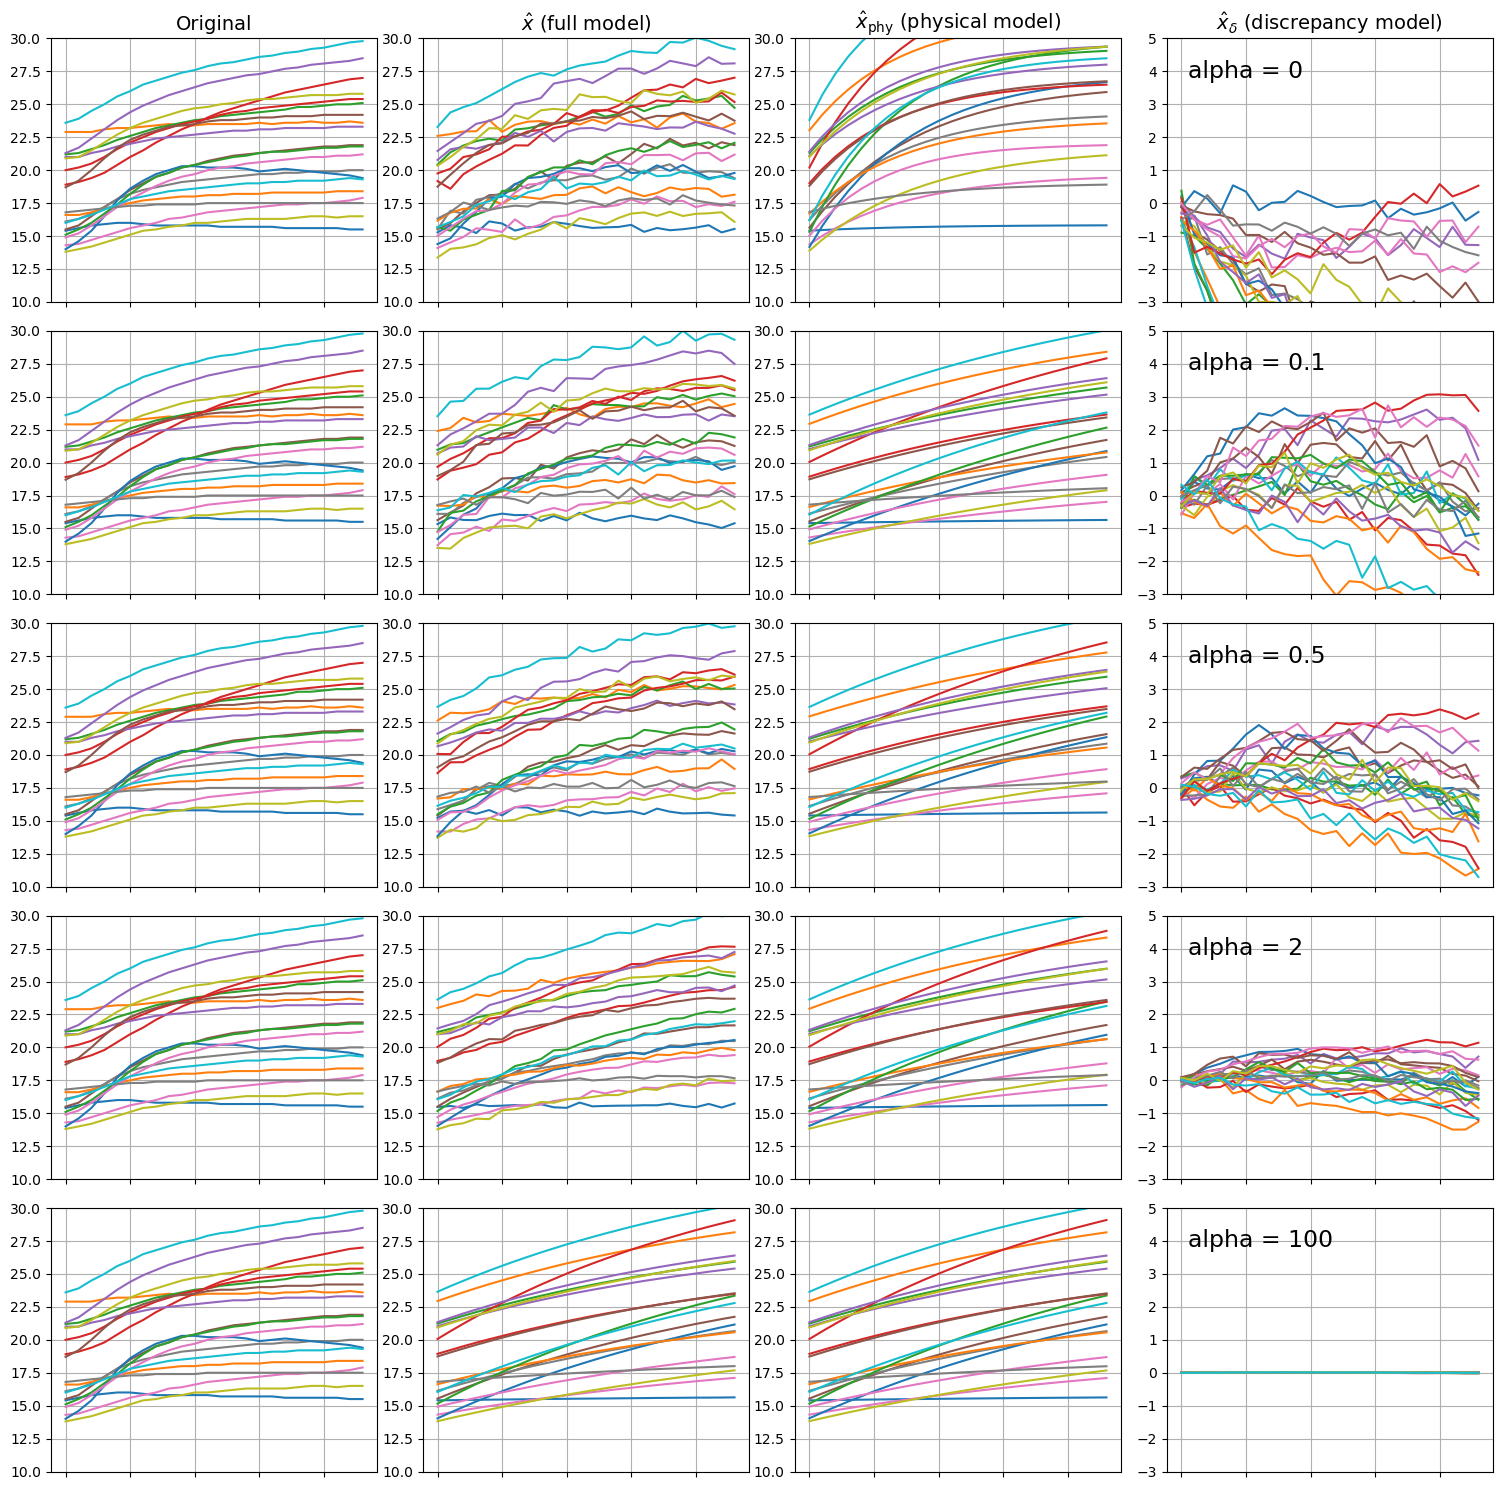

In [22]:
"""initial_alpha_values = [0, 0.1, 0.5, 2, 100]
num_alphas = len(initial_alpha_values)

fig, axs = plt.subplots(num_alphas, 4, figsize=(15, 3 * num_alphas), sharex=True)

for idx, alpha in enumerate(initial_alpha_values):
    model_path = f'pre_trained_models/ablation/PIGPVAE_heating_alpha_{alpha}.pth'
    print(f'Loading model from {model_path}')
    
    # 1. Load the trained model
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    GP_inf = GP_inference(kernel)
    
    model = PIGPVAE(GP_inf=GP_inf, 
                    hidden_layers_encoder_delta=[10,10], 
                    hidden_layers_encoder_phy=[10], 
                    hidden_layers_decoder_delta=[10,10],
                    activation_decoder_delta=nn.ELU(),
                    initial_alpha=alpha,
                    trainable_alpha=False,
                    mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
                   )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 2. Gather outputs for all samples
    q_mu_delta_l, q_var_delta_l = [], []
    q_mu_phy_l, q_var_phy_l = [], []
    x_hat_l, x_hat_phy_l, x_hat_delta_l = [], [], []
    batches_data = []
    
    for x_batch in train_loader:
        with torch.no_grad():
            x_batch = x_batch.squeeze(0)
            (
                x_hat_i,
                x_hat_phy_i,
                x_hat_delta_i,
                _,
                _,
                _,
                q_mu_delta_i,
                q_var_delta_i,
                q_mu_phy_i,
                q_var_phy_i
            ) = model(x_batch)
            
            x_hat_l.append(x_hat_i)
            x_hat_phy_l.append(x_hat_phy_i)
            x_hat_delta_l.append(x_hat_delta_i)
            q_mu_delta_l.append(q_mu_delta_i)
            q_var_delta_l.append(q_var_delta_i)
            q_mu_phy_l.append(q_mu_phy_i)
            q_var_phy_l.append(q_var_phy_i)
            batches_data.append(x_batch)
    
    # 3. Convert to numpy arrays for plotting
    x_hat_numpy = [x.detach().cpu().numpy() for x in x_hat_l]
    batches_data_numpy = [b[:, 0].unsqueeze(1).detach().cpu().numpy() for b in batches_data]
    x_hat_phy_numpy = [x.detach().cpu().numpy() for x in x_hat_phy_l]
    x_hat_delta_numpy = [x.detach().cpu().numpy() for x in x_hat_delta_l]
    
    # 4. Plot the data for this alpha in the appropriate row
    for col, (data, title) in enumerate(zip(
        [batches_data_numpy, x_hat_numpy, x_hat_phy_numpy, x_hat_delta_numpy],
        [r'Original', r'$\hat{x}$ (full model)', r'$\hat{x}_{\text{phy}}$ (physical model)', r'$\hat{x}_{\delta}$ (discrepancy model)']
    )):
        for i in range(len(data)):
            axs[idx, col].plot(data[i], label=f'Sample {i}' if i == 0 else None)
        
        # Add title only for the first row
        if idx == 0:
            axs[idx, col].set_title(title, fontsize=14)
        
        # Hide x-axis labels except for the last row
        if idx < num_alphas - 1:
            axs[idx, col].set_xticklabels([])
        else: 
            axs[idx, col].tick_params(axis='x', labelbottom=True)
    
    # Set y-limits for specific plots
    axs[idx, 0].set_ylim(10, 30)  # Original data
    axs[idx, 1].set_ylim(10, 30)  # x_hat (full model)
    axs[idx, 2].set_ylim(10, 30)  # x_hat_phy (physical model)
    axs[idx, 3].set_ylim(-3, 5)   # x_hat_delta (discrepancy model)
    
    # Add alpha legend in the top-left of the discrepancy plot (axs[idx, 3])
    axs[idx, 3].legend([f'alpha = {alpha}'], loc='upper left', frameon=False, 
                        handlelength=0, handletextpad=0, prop={'size': 17})

    for ax in axs[idx, :]:
        ax.grid(True)

plt.tight_layout()
plt.show()
"""

Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.1.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.5.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.91.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_2.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_100.pth


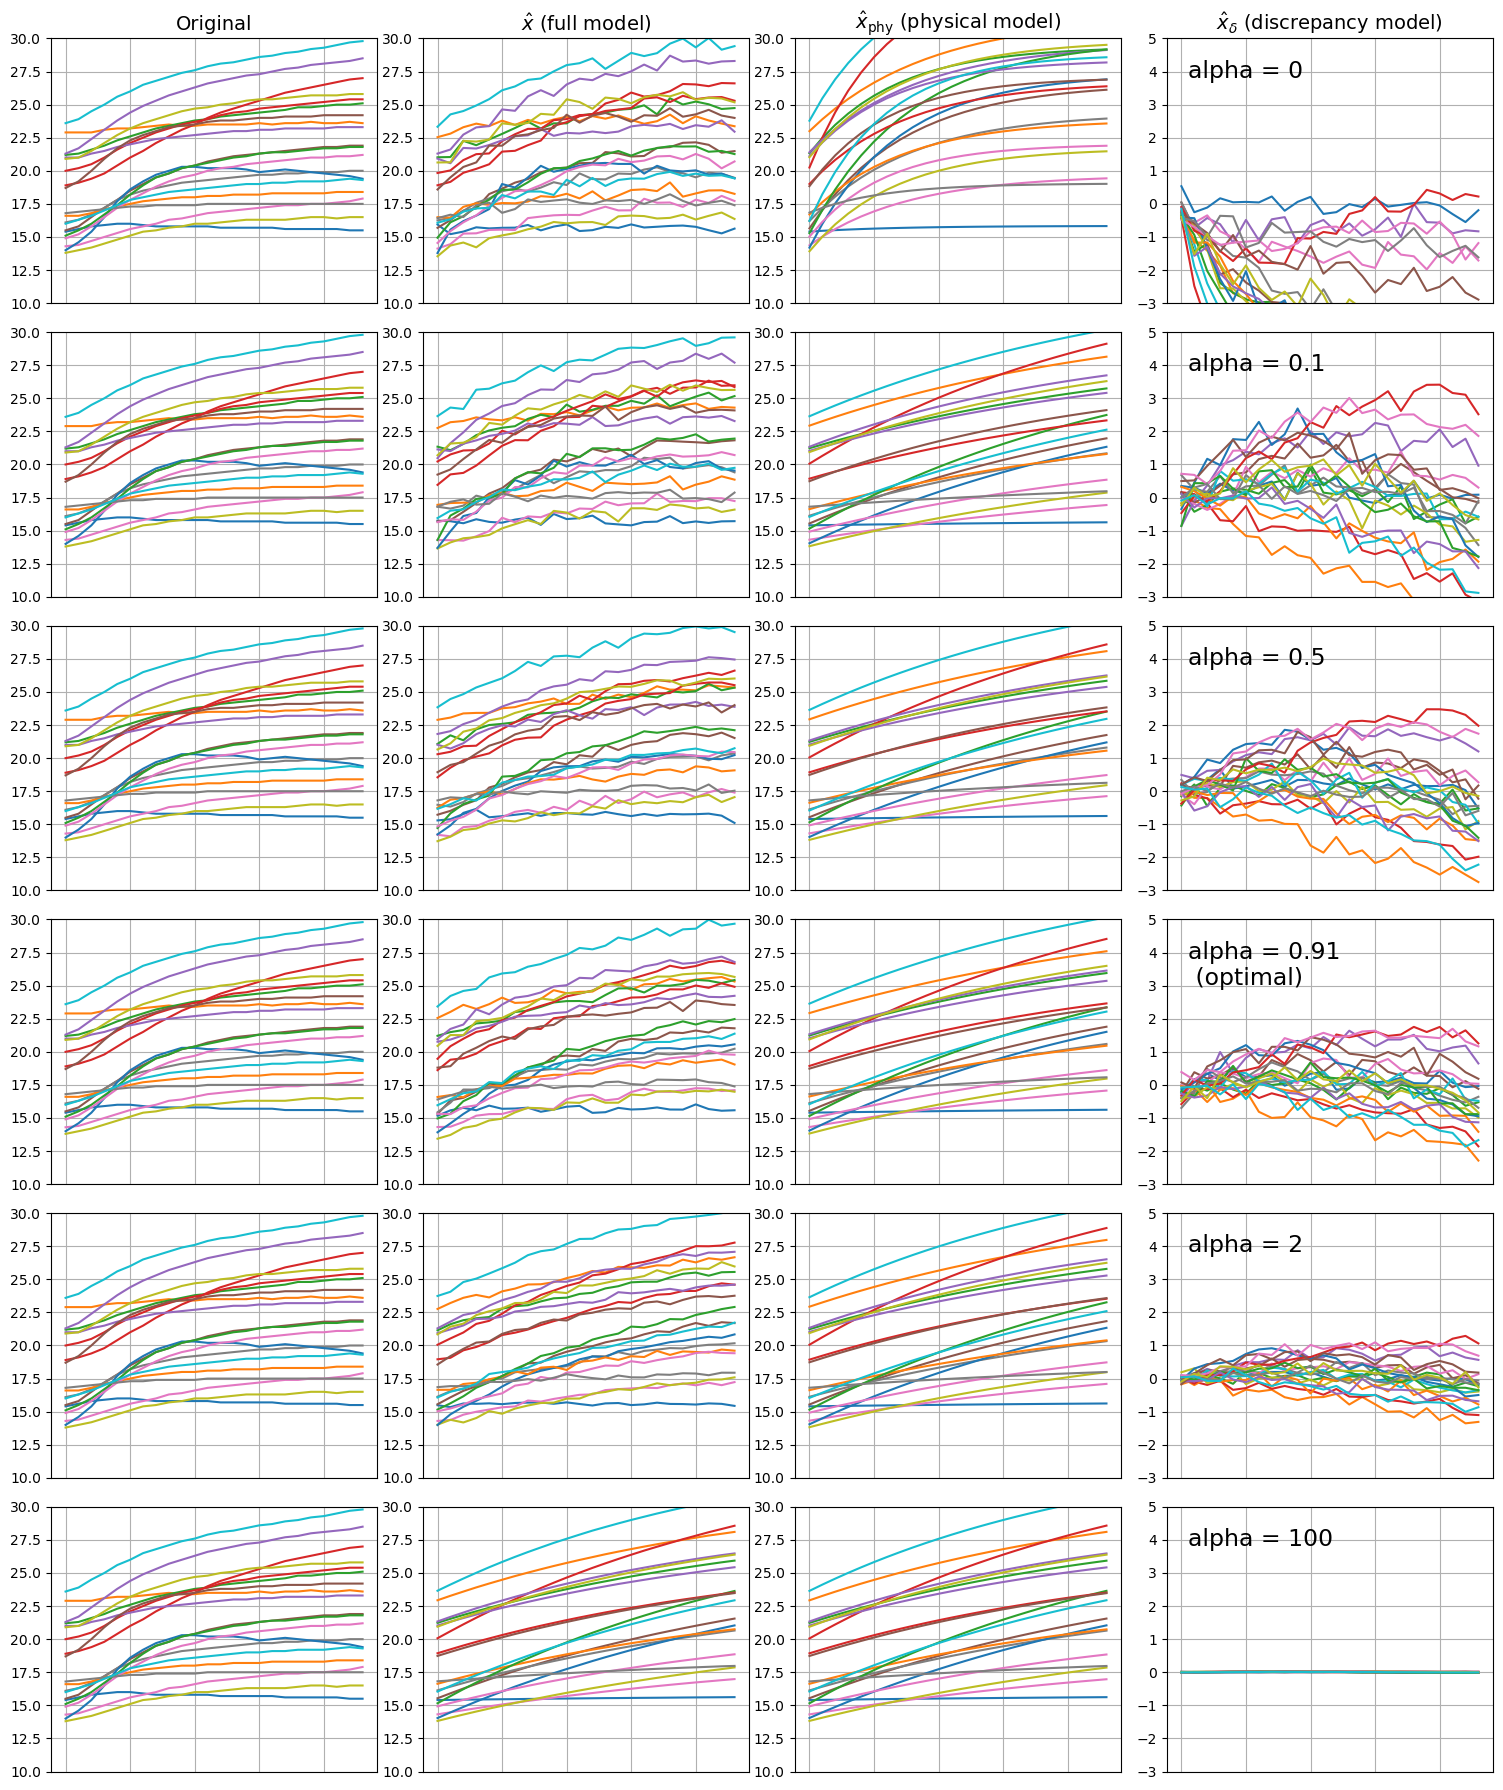

In [24]:
"""initial_alpha_values = [0, 0.1, 0.5, 0.91, 2, 100]
num_alphas = len(initial_alpha_values)

fig, axs = plt.subplots(num_alphas, 4, figsize=(15, 3 * num_alphas), sharex=True)

for idx, alpha in enumerate(initial_alpha_values):
    model_path = f'pre_trained_models/ablation/PIGPVAE_heating_alpha_{alpha}.pth'
    print(f'Loading model from {model_path}')
    
    # 1. Load the trained model
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    GP_inf = GP_inference(kernel)
    
    # If alpha == 0.91, set trainable_alpha=True
    trainable_alpha_flag = True if alpha == 0.91 else False
    
    model = PIGPVAE(GP_inf=GP_inf, 
                    hidden_layers_encoder_delta=[10,10], 
                    hidden_layers_encoder_phy=[10], 
                    hidden_layers_decoder_delta=[10,10],
                    activation_decoder_delta=nn.ELU(),
                    initial_alpha=alpha,
                    trainable_alpha=trainable_alpha_flag,
                    mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
                   )
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 2. Gather outputs for all samples
    q_mu_delta_l, q_var_delta_l = [], []
    q_mu_phy_l, q_var_phy_l = [], []
    x_hat_l, x_hat_phy_l, x_hat_delta_l = [], [], []
    batches_data = []
    
    for x_batch in train_loader:
        with torch.no_grad():
            x_batch = x_batch.squeeze(0)
            (
                x_hat_i,
                x_hat_phy_i,
                x_hat_delta_i,
                _,
                _,
                _,
                q_mu_delta_i,
                q_var_delta_i,
                q_mu_phy_i,
                q_var_phy_i
            ) = model(x_batch)
            
            x_hat_l.append(x_hat_i)
            x_hat_phy_l.append(x_hat_phy_i)
            x_hat_delta_l.append(x_hat_delta_i)
            q_mu_delta_l.append(q_mu_delta_i)
            q_var_delta_l.append(q_var_delta_i)
            q_mu_phy_l.append(q_mu_phy_i)
            q_var_phy_l.append(q_var_phy_i)
            batches_data.append(x_batch)
    
    # 3. Convert to numpy arrays for plotting
    x_hat_numpy = [x.detach().cpu().numpy() for x in x_hat_l]
    batches_data_numpy = [b[:, 0].unsqueeze(1).detach().cpu().numpy() for b in batches_data]
    x_hat_phy_numpy = [x.detach().cpu().numpy() for x in x_hat_phy_l]
    x_hat_delta_numpy = [x.detach().cpu().numpy() for x in x_hat_delta_l]
    
    # 4. Plot the data for this alpha in the appropriate row
    for col, (data, title) in enumerate(zip(
        [batches_data_numpy, x_hat_numpy, x_hat_phy_numpy, x_hat_delta_numpy],
        [r'Original', r'$\hat{x}$ (full model)', r'$\hat{x}_{\text{phy}}$ (physical model)', r'$\hat{x}_{\delta}$ (discrepancy model)']
    )):
        for i in range(len(data)):
            axs[idx, col].plot(data[i], label=f'Sample {i}' if i == 0 else None)
        
        # Add title only for the first row
        if idx == 0:
            axs[idx, col].set_title(title, fontsize=14)
        
        # Remove x-axis ticks
        axs[idx, col].tick_params(axis='x', which='both', bottom=False, top=False)
        
        # Hide x-axis labels except for the last row
        if idx < num_alphas - 1:
            axs[idx, col].set_xticklabels([])
        else: 
            axs[idx, col].tick_params(axis='x', labelbottom=True)
    
    # Set y-limits for specific plots
    axs[idx, 0].set_ylim(10, 30)  # Original data
    axs[idx, 1].set_ylim(10, 30)  # x_hat (full model)
    axs[idx, 2].set_ylim(10, 30)  # x_hat_phy (physical model)
    axs[idx, 3].set_ylim(-3, 5)   # x_hat_delta (discrepancy model)
    
    # Add alpha legend in the top-left of the discrepancy plot (axs[idx, 3])
    if alpha == 0.91:
        axs[idx, 3].legend([f'alpha = {alpha} \n (optimal)'], loc='upper left', frameon=False, 
                           handlelength=0, handletextpad=0, prop={'size': 17})
    else:
        axs[idx, 3].legend([f'alpha = {alpha}'], loc='upper left', frameon=False, 
                           handlelength=0, handletextpad=0, prop={'size': 17})

    for ax in axs[idx, :]:
        ax.grid(True)

plt.tight_layout()
plt.show()
"""

Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.pth


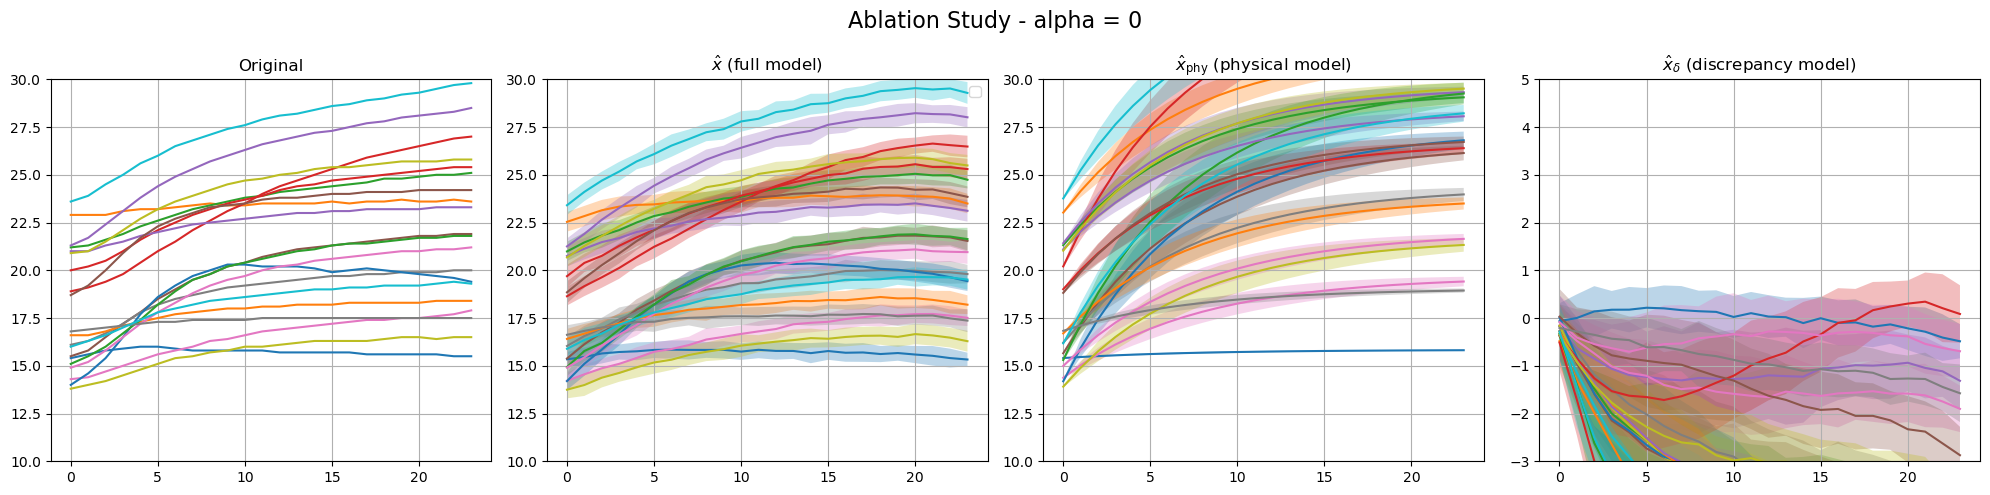

Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.1.pth


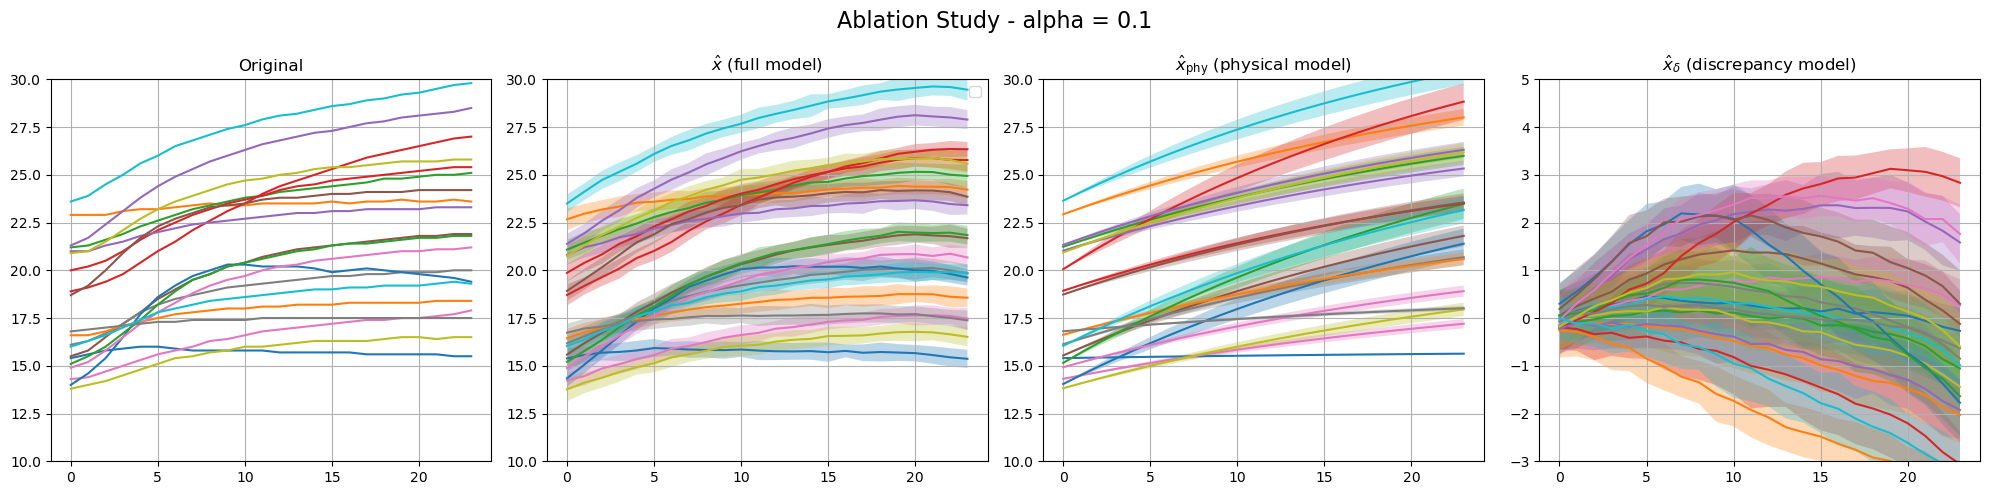

Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.5.pth


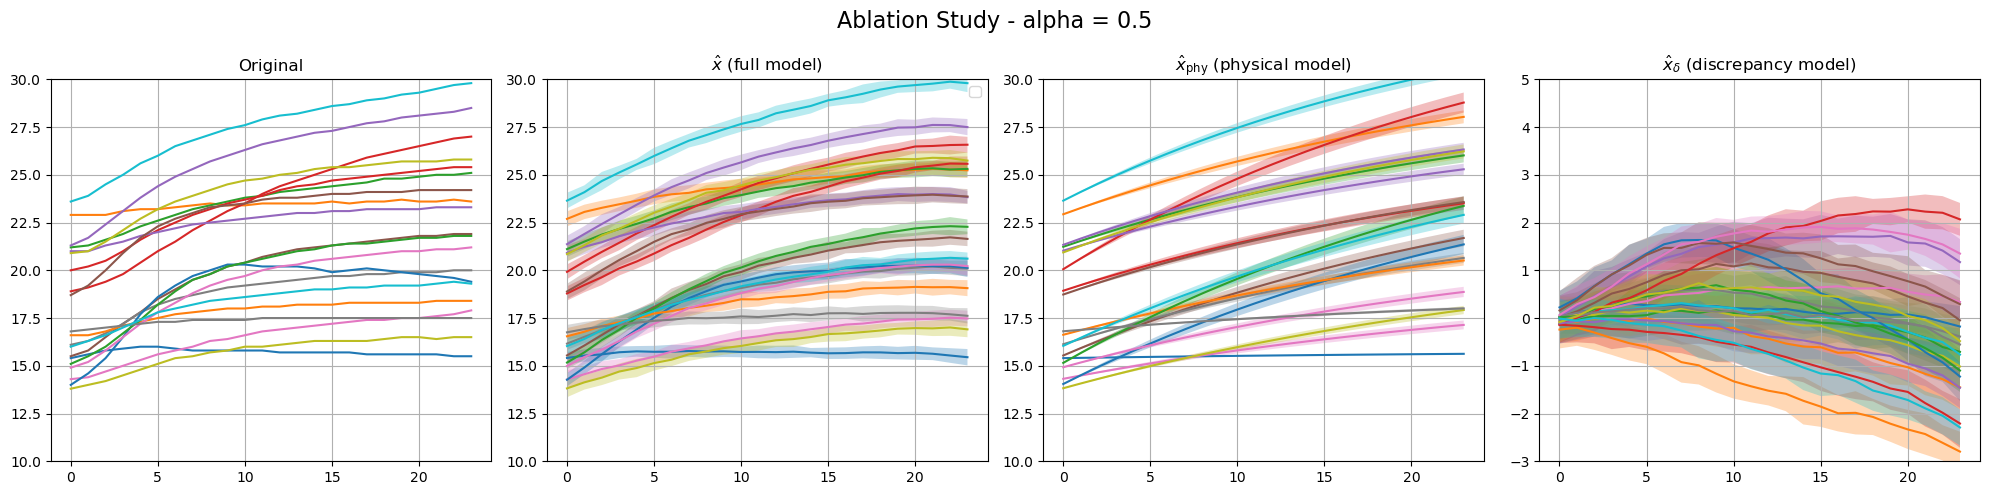

Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.91.pth


RuntimeError: Error(s) in loading state_dict for PIGPVAE:
	Unexpected key(s) in state_dict: "raw_alpha". 

In [25]:
"""def compute_mean_and_ci(samples):
    """
    Compute mean and 95% confidence intervals using the standard error.
    samples: NumPy array [num_samples, sequence_length]
    """
    mean = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    ci = 1.96 * std
    lower_bound = mean - ci
    upper_bound = mean + ci
    return mean, lower_bound, upper_bound

# Number of samples to draw for confidence intervals
num_samples = 50

initial_alpha_values = [0, 0.1, 0.5, 0.91, 2, 100]
for alpha in initial_alpha_values:
    # 1. Build model path and load the trained model
    model_path = f'pre_trained_models/ablation/PIGPVAE_heating_alpha_{alpha}.pth'
    print(f'Loading model from {model_path}')
    
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    GP_inf = GP_inference(kernel)
    
    model = PIGPVAE(GP_inf=GP_inf, 
                    hidden_layers_encoder_delta=[10,10], 
                    hidden_layers_encoder_phy=[10], 
                    hidden_layers_decoder_delta=[10,10],
                    activation_decoder_delta=nn.ELU(),
                    initial_alpha=alpha,
                    trainable_alpha=trainable_alpha_flag,
                    mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
                   )
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # 2. For each batch, sample num_samples times from the model
    x_hat_samples, x_hat_phy_samples, x_hat_delta_samples = [], [], []
    batches_data_numpy = []  # to store the original data for plotting

    for x_batch in train_loader:
        with torch.no_grad():
            # Remove batch dimension if it is an extra dimension of size 1
            x_batch = x_batch.squeeze(0)  # shape [batch_size, ...] or [seq_len, ...]
        
        # We'll collect multiple samples of x_hat, x_hat_phy, x_hat_delta
        tmp_x_hat = []
        tmp_x_hat_phy = []
        tmp_x_hat_delta = []
        
        # Collect the original data for reference (e.g., temperature)
        # Suppose the data of interest is in x_batch[:, 0]
        # You might adjust based on how your data is structured
        batches_data_numpy.append(x_batch[:, 0].cpu().numpy())

        for _ in range(num_samples):
            with torch.no_grad():
                (
                    x_hat_i,
                    x_hat_phy_i,
                    x_hat_delta_i,
                    _,
                    _,
                    _,
                    q_mu_delta_i,
                    q_var_delta_i,
                    q_mu_phy_i,
                    q_var_phy_i
                ) = model(x_batch)
                
            # Convert to NumPy on CPU
            tmp_x_hat.append(x_hat_i.cpu().numpy().flatten())
            tmp_x_hat_phy.append(x_hat_phy_i.cpu().numpy().flatten())
            tmp_x_hat_delta.append(x_hat_delta_i.cpu().numpy().flatten())

        # Stack: shape = [num_samples, sequence_length]
        x_hat_samples.append(np.stack(tmp_x_hat))
        x_hat_phy_samples.append(np.stack(tmp_x_hat_phy))
        x_hat_delta_samples.append(np.stack(tmp_x_hat_delta))

    # 3. Create a figure for this alpha
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Ablation Study - alpha = {alpha}", fontsize=16)

    # We'll assume #batches in train_loader is the same as len(x_hat_samples)
    num_batches = len(x_hat_samples)

    # 4a. Plot the Original Data in axs[0]
    for i in range(num_batches):
        axs[0].plot(batches_data_numpy[i], label=f'Batch {i}' if i == 0 else None)
    axs[0].set_title("Original")
    axs[0].set_ylim(10, 30)
    axs[0].grid(True)

    # 4b. Plot the Full Model in axs[1] with Mean & 95% CI
    axs[1].set_title(r'$\hat{x}$ (full model)')
    axs[1].set_ylim(10, 30)
    axs[1].grid(True)
    for i in range(num_batches):
        mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat_samples[i])
        axs[1].plot(mean_x_hat)
        axs[1].fill_between(
            range(len(mean_x_hat)),
            lower_x_hat,
            upper_x_hat,
            alpha=0.3
        )

    # 4c. Physical Model in axs[2]
    axs[2].set_title(r'$\hat{x}_{\text{phy}}$ (physical model)')
    axs[2].set_ylim(10, 30)
    axs[2].grid(True)
    for i in range(num_batches):
        mean_x_phy, lower_x_phy, upper_x_phy = compute_mean_and_ci(x_hat_phy_samples[i])
        axs[2].plot(mean_x_phy, label=f'Batch {i} Mean')
        axs[2].fill_between(
            range(len(mean_x_phy)),
            lower_x_phy,
            upper_x_phy,
            alpha=0.3
        )

    # 4d. Discrepancy Model in axs[3]
    axs[3].set_title(r'$\hat{x}_{\delta}$ (discrepancy model)')
    axs[3].set_ylim(-3, 5)
    axs[3].grid(True)
    for i in range(num_batches):
        mean_x_delta, lower_x_delta, upper_x_delta = compute_mean_and_ci(x_hat_delta_samples[i])
        axs[3].plot(mean_x_delta, label=f'Batch {i} Mean')
        axs[3].fill_between(
            range(len(mean_x_delta)),
            lower_x_delta,
            upper_x_delta,
            alpha=0.3
        )

    # 5. Legend & layout
    # If you want legends on each subplot, remove "if i == 0" condition above or add it here
    axs[1].legend()  # example: add legend on the full model subplot

    plt.tight_layout()
    plt.show()
"""

Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.1.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.5.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.91.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_2.pth
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_100.pth


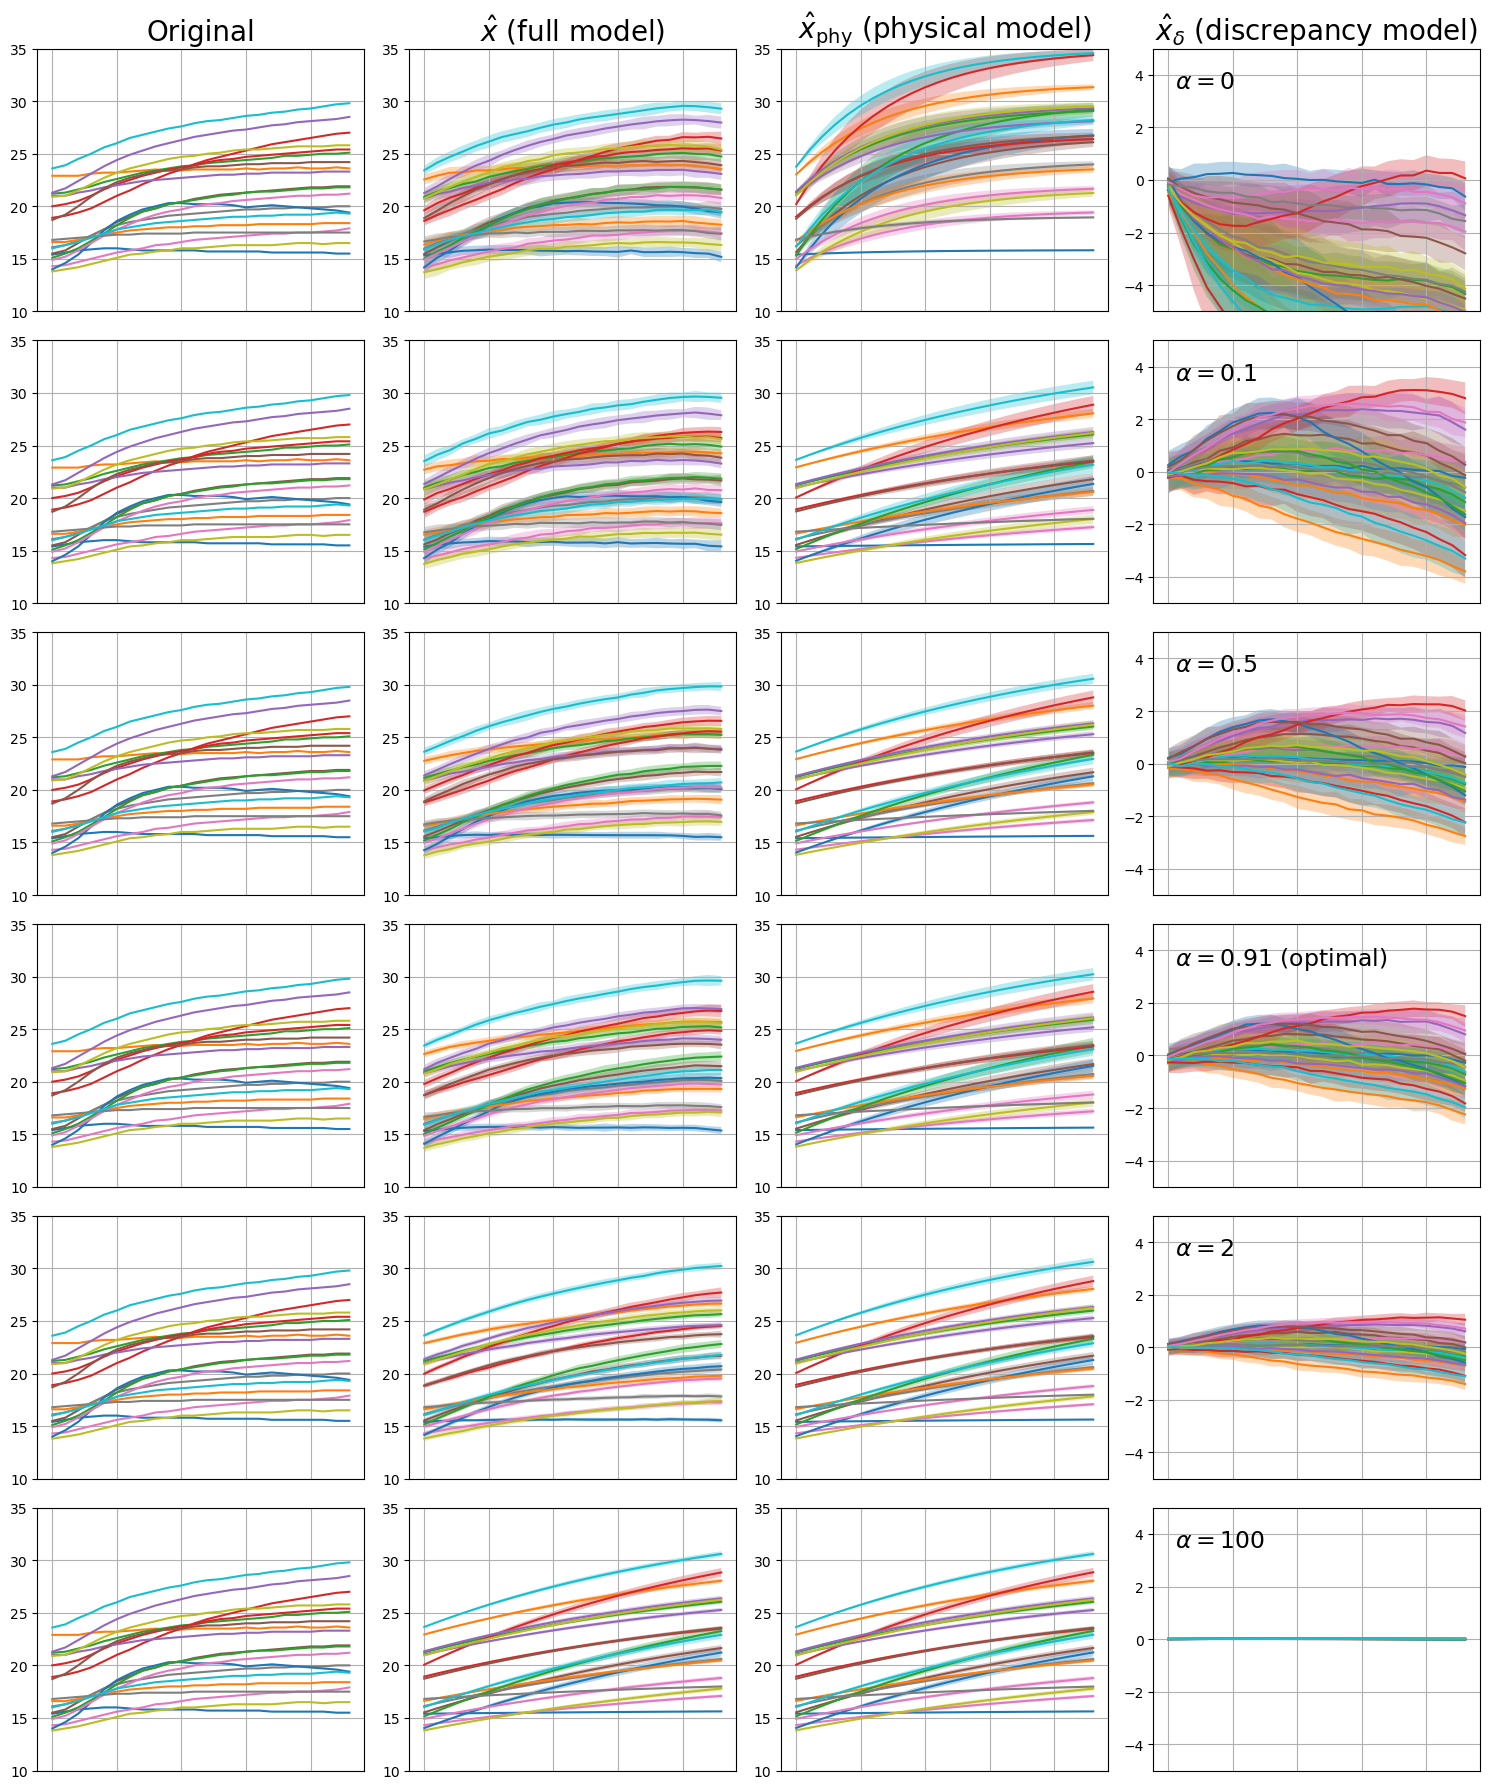

In [6]:
title_fontsize = 20

def compute_mean_and_ci(samples):
    """
    Compute mean and 95% confidence intervals using the standard error.
    samples: NumPy array [num_samples, sequence_length]
    """
    mean = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    ci = 1.96 * std 
    lower_bound = mean - ci
    upper_bound = mean + ci
    return mean, lower_bound, upper_bound

# Number of samples to draw for confidence intervals
num_samples = 50

initial_alpha_values = [0, 0.1, 0.5, 0.91, 2, 100]
num_alphas = len(initial_alpha_values)

fig, axs = plt.subplots(num_alphas, 4, figsize=(15, 3 * num_alphas), sharex=True)

for idx, alpha in enumerate(initial_alpha_values):
    model_path = f'pre_trained_models/ablation/PIGPVAE_heating_alpha_{alpha}.pth'
    print(f'Loading model from {model_path}')
    
    # 1. Load the trained model
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    GP_inf = GP_inference(kernel)
    
    # If alpha == 0.91, set trainable_alpha=True
    trainable_alpha_flag = True if alpha == 0.91 else False
    model = PIGPVAE(GP_inf=GP_inf, 
                    hidden_layers_encoder_delta=[10,10], 
                    hidden_layers_encoder_phy=[10], 
                    hidden_layers_decoder_delta=[10,10],
                    activation_decoder_delta=nn.ELU(),
                    initial_alpha=alpha,
                    trainable_alpha=trainable_alpha_flag,
                    mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
                   )
    

    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 2. For each batch in the training set, we sample 'num_samples' times
    #    to compute mean and CI for x_hat, x_hat_phy, and x_hat_delta.
    x_hat_samples = []
    x_hat_phy_samples = []
    x_hat_delta_samples = []
    batches_data_numpy = []

    for x_batch in train_loader:
        with torch.no_grad():
            x_batch = x_batch.squeeze(0)  # shape [batch_size, ...]
        
        # We'll collect multiple samples of x_hat, x_hat_phy, x_hat_delta
        tmp_x_hat = []
        tmp_x_hat_phy = []
        tmp_x_hat_delta = []

        # Store the "original data" of interest
        # Suppose temperature is x_batch[:, 0]
        batches_data_numpy.append(x_batch[:, 0].cpu().numpy())

        # Repeated forward passes (assuming there's randomness in your VAE)
        for _ in range(num_samples):
            with torch.no_grad():
                (
                    x_hat_i,
                    x_hat_phy_i,
                    x_hat_delta_i,
                    _,
                    _,
                    _,
                    q_mu_delta_i,
                    q_var_delta_i,
                    q_mu_phy_i,
                    q_var_phy_i
                ) = model(x_batch)
            
            # Convert to NumPy and flatten (if needed)
            tmp_x_hat.append(x_hat_i.cpu().numpy().flatten())
            tmp_x_hat_phy.append(x_hat_phy_i.cpu().numpy().flatten())
            tmp_x_hat_delta.append(x_hat_delta_i.cpu().numpy().flatten())

        # Stack => shape [num_samples, sequence_length]
        x_hat_samples.append(np.stack(tmp_x_hat))
        x_hat_phy_samples.append(np.stack(tmp_x_hat_phy))
        x_hat_delta_samples.append(np.stack(tmp_x_hat_delta))
    
    # 3. Plot Original Data in column 0
    for i in range(len(batches_data_numpy)):
        # Each batch gets its own line
        axs[idx, 0].plot(batches_data_numpy[i], label=f'Sample {i}' if i == 0 else None)
    # Only set title in the first row
    if idx == 0:
        axs[idx, 0].set_title(r'Original', fontsize=title_fontsize)
    axs[idx, 0].set_ylim(10, 35)
    axs[idx, 0].tick_params(axis='x', which='both', bottom=False, top=False)
    if idx < num_alphas - 1:
        axs[idx, 0].set_xticklabels([])
    axs[idx, 0].grid(True)

    # 4. Plot Full Model (x_hat) in column 1 with Mean & 95% CI
    for i in range(len(x_hat_samples)):
        mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat_samples[i])
        axs[idx, 1].plot(mean_x_hat, label=f'Batch {i} Mean' if i == 0 else None)
        axs[idx, 1].fill_between(
            range(len(mean_x_hat)),
            lower_x_hat,
            upper_x_hat,
            alpha=0.3
        )
    if idx == 0:
        axs[idx, 1].set_title(r'$\hat{x}$ (full model)', fontsize=title_fontsize)
    axs[idx, 1].set_ylim(10, 35)
    axs[idx, 1].tick_params(axis='x', which='both', bottom=False, top=False)
    if idx < num_alphas - 1:
        axs[idx, 1].set_xticklabels([])
    axs[idx, 1].grid(True)

    # 5. Plot Physical Model (x_hat_phy) in column 2 with Mean & 95% CI
    for i in range(len(x_hat_phy_samples)):
        mean_x_phy, lower_x_phy, upper_x_phy = compute_mean_and_ci(x_hat_phy_samples[i])
        axs[idx, 2].plot(mean_x_phy, label=f'Batch {i} Mean' if i == 0 else None)
        axs[idx, 2].fill_between(
            range(len(mean_x_phy)),
            lower_x_phy,
            upper_x_phy,
            alpha=0.3
        )
    if idx == 0:
        axs[idx, 2].set_title(r'$\hat{x}_{\text{phy}}$ (physical model)', fontsize=title_fontsize)
    axs[idx, 2].set_ylim(10, 35)
    axs[idx, 2].tick_params(axis='x', which='both', bottom=False, top=False)
    if idx < num_alphas - 1:
        axs[idx, 2].set_xticklabels([])
    axs[idx, 2].grid(True)

    # 6. Plot Discrepancy Model (x_hat_delta) in column 3 with Mean & 95% CI
    for i in range(len(x_hat_delta_samples)):
        mean_x_delta, lower_x_delta, upper_x_delta = compute_mean_and_ci(x_hat_delta_samples[i])
        axs[idx, 3].plot(mean_x_delta, label=f'Batch {i} Mean' if i == 0 else None)
        axs[idx, 3].fill_between(
            range(len(mean_x_delta)),
            lower_x_delta,
            upper_x_delta,
            alpha=0.3
        )
    if idx == 0:
        axs[idx, 3].set_title(r'$\hat{x}_{\delta}$ (discrepancy model)', fontsize=title_fontsize)
    axs[idx, 3].set_ylim(-5, 5)
    axs[idx, 3].tick_params(axis='x', which='both', bottom=False, top=False)
    if idx < num_alphas - 1:
        axs[idx, 3].set_xticklabels([])
    axs[idx, 3].grid(True)

    # 7. Add alpha legend in the top-left of the discrepancy plot (axs[idx, 3])
    if alpha == 0.91:
        axs[idx, 3].legend([fr'$\alpha = {alpha}$ (optimal)'], loc='upper left', frameon=False,
                           handlelength=0, handletextpad=0, prop={'size': 17})
    else:
        axs[idx, 3].legend([fr'$\alpha = {alpha}$'], loc='upper left', frameon=False,
                           handlelength=0, handletextpad=0, prop={'size': 17})
    
plt.tight_layout()
plt.savefig("figs/ablation_heating.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [9]:
full_data = DataLoader(dataset)
original_data_list = []
for batch in full_data:
    # Each batch is expected to be of shape [24, 1]
    # Add to the list
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)

In [11]:
metrics = SyntheticDataMetrics()

initial_alpha_values = [0, 0.1, 0.5, 0.91, 2, 100]
num_datasets = 100
min_T, max_T = 16, 30
t_uni = torch.tensor([
        1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.
    ])
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
results_all_alphas = []

for alpha in initial_alpha_values:
    print(f"==== Computing metrics for alpha = {alpha} ====")
    
    # 1) Load the model
    model_path = f'pre_trained_models/ablation/PIGPVAE_heating_alpha_{alpha}.pth'
    print(f"Loading model from {model_path}")
    
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    GP_inf = GP_inference(kernel)
    
    trainable_alpha_flag = (alpha == 0.91)

    model = PIGPVAE(GP_inf=GP_inf, 
                    hidden_layers_encoder_delta=[10,10], 
                    hidden_layers_encoder_phy=[10], 
                    hidden_layers_decoder_delta=[10,10],
                    activation_decoder_delta=nn.ELU(),
                    initial_alpha=alpha,
                    trainable_alpha=trainable_alpha_flag,
                    mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
                   )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 2) Obtain q_mu_delta, q_mu_phy, q_var_phy from the training data
    q_mu_delta_l = []
    q_mu_phy_l   = []
    q_var_phy_l  = []
    
    # Assume you have a DataLoader named `train_loader`
    for x_batch in train_loader:
        with torch.no_grad():
            # Remove extra batch dimension if needed
            x_batch = x_batch.squeeze(0)  # shape: [batch_size, ...]
            
            # Forward pass: the model returns many outputs; we only unpack what we need
            (
                _,
                _,
                _,
                _,
                _,
                _,
                q_mu_delta_i,
                _,
                q_mu_phy_i,
                q_var_phy_i
            ) = model(x_batch)
            
            q_mu_delta_l.append(q_mu_delta_i)  # shape [batch_size, latent_dim] or similar
            q_mu_phy_l.append(q_mu_phy_i)
            q_var_phy_l.append(q_var_phy_i)
    
    # 3) Compute mean of these latent variables/parameters
    #    e.g., if each q_mu_phy_i is shape [batch_size, something], we sum them up, then divide:
    mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
    mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)
    
    # For q_mu_delta, often we horizontally concatenate then average across the second dimension
    # The shape of each q_mu_delta_i is [batch_size, latent_dim], so we cat along dim=0 or dim=1:
    # The snippet you showed suggests cat along dim=1, so let's keep that pattern:
    q_mu_delta_cat = torch.cat(q_mu_delta_l, dim=1)  # shape [latent_dim, sum_of_batch_sizes]
    mu_s_PIGPVAE = q_mu_delta_cat.mean(dim=1).unsqueeze(1)  # shape [latent_dim, 1]
    
    # If your code expects [latent_dim, 1], this is correct. 
    # If you need shape [1, latent_dim], you might transpose or adapt accordingly.
    
    # 4) Now, we can proceed with generating synthetic data & computing metrics
    #    For example:
    mmd_vals = []
    corr_vals = []
    mdd_vals = []
    
    # We'll do the same random T0/Ts approach for each alpha
    for i in range(num_datasets):
        min_T, max_T = 11, 30
        torch.manual_seed(0)
        T0 = min_T + (max_T - min_T) * torch.rand(ns)
        difference = 1 + (20 - 1) * torch.rand(ns)
        Ts = T0 + difference
        """T0 = min_T + (max_T - min_T) * torch.rand(ns)
        difference = 1 + (20 - 1) * torch.rand(ns)
        Ts = T0 - difference"""
        
        # This is the typical call to your model's generator:
        # `generate_and_plot` might need all these arguments:
        k_values, gd_list, fig, axs = model.generate_and_plot(
            mu_s_PIGPVAE,        # from q_mu_delta
            mean_q_mu_phy,       # from q_mu_phy
            mean_q_var_phy,      # from q_var_phy
            df=df_h,             # or whatever your code references
            num_unique_intervals=num_unique_intervals,
            ns=ns,
            T0=T0,
            Ts=Ts,
            t_uni=t_uni / 240,
            axs_ylim=(0, 35),
            plot=False,
            seed=i
        )
        
        # Once generated, compute your metrics:
        Gd_tensor = torch.stack(gd_list)  # shape depends on your usage
        mmd_val = metrics.compute_mmd(original_data, Gd_tensor)
        corr_val = metrics.correlation_metric(original_data, gd_list)
        mdd_val = metrics.compute_mdd(original_data, gd_list)
        
        mmd_vals.append(mmd_val)
        corr_vals.append(corr_val)
        mdd_vals.append(mdd_val)
    
    # 5) After the loop over synthetic datasets, compute stats for each metric
    mmd_t  = torch.tensor(mmd_vals)
    corr_t = torch.tensor(corr_vals)
    mdd_t  = torch.tensor(mdd_vals)
    
    mmd_mean,  mmd_std  = mmd_t.mean().item(),  mmd_t.std().item()
    corr_mean, corr_std = corr_t.mean().item(), corr_t.std().item()
    mdd_mean,  mdd_std  = mdd_t.mean().item(),  mdd_t.std().item()
    
    print(f"[Alpha = {alpha}] MMD:       mean = {mmd_mean:.4f},  std = {mmd_std:.4f}")
    print(f"[Alpha = {alpha}] Corr:      mean = {corr_mean:.4f}, std = {corr_std:.4f}")
    print(f"[Alpha = {alpha}] MDD:       mean = {mdd_mean:.4f},  std = {mdd_std:.4f}\n")
    
    results_all_alphas.append({
        'alpha': alpha,
        'MMD_mean': mmd_mean,  'MMD_std': mmd_std,
        'Corr_mean': corr_mean,'Corr_std': corr_std,
        'MDD_mean': mdd_mean,  'MDD_std': mdd_std
    })

# (Optional) Print final summary
import pandas as pd
df_results = pd.DataFrame(results_all_alphas)
print(df_results)


==== Computing metrics for alpha = 0 ====
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.pth
[Alpha = 0] MMD:       mean = 0.0800,  std = 0.0046
[Alpha = 0] Corr:      mean = 99.5969, std = 9.4733
[Alpha = 0] MDD:       mean = 0.0314,  std = 0.0027

==== Computing metrics for alpha = 0.1 ====
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.1.pth
[Alpha = 0.1] MMD:       mean = 0.0742,  std = 0.0043
[Alpha = 0.1] Corr:      mean = 98.1460, std = 9.1330
[Alpha = 0.1] MDD:       mean = 0.0245,  std = 0.0022

==== Computing metrics for alpha = 0.5 ====
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.5.pth
[Alpha = 0.5] MMD:       mean = 0.0700,  std = 0.0038
[Alpha = 0.5] Corr:      mean = 95.6540, std = 7.7288
[Alpha = 0.5] MDD:       mean = 0.0179,  std = 0.0015

==== Computing metrics for alpha = 0.91 ====
Loading model from pre_trained_models/ablation/PIGPVAE_heating_alpha_0.91.pth
[Alpha = 0.91] MMD:       mean = 0.